# LOAD MODULES

In [1]:
%load_ext autoreload
%autoreload 2
# 2 reloads modules every time a cell is executed

import re, os, sys, errno, glob, argparse
os.chdir("/home/momoshog/Tornado/tornado_jtti")

from datetime import timedelta, datetime, date, time
from dateutil.parser import parse as parse_date
import xarray as xr
print("xr version", xr.__version__)
import numpy as np
print("np version", np.__version__)
import pandas as pd
print("pd version", pd.__version__)
#import netCDF4
#print("netCDF4 version", netCDF4.__version__)
from netCDF4 import Dataset, date2num, num2date
#import scipy
#print("scipy version", scipy.__version__)
from scipy import spatial
from scipy.ndimage import uniform_filter, generic_filter, binary_dilation, grey_dilation
#from scipy.interpolate import RectBivariateSpline
import wrf #wrf-python=1.3.2.5==py38h0e9072a_0
print("wrf-python version", wrf.__version__)
import metpy
import metpy.calc

import matplotlib.pyplot as plt
import matplotlib as mpl

import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots
py.init_notebook_mode(connected=True)

#import pickle
from sklearn.metrics import confusion_matrix

import tensorflow as tf
print("tensorflow version", tf.__version__)
from tensorflow import keras
print("keras version", keras.__version__)
from keras_tuner import HyperParameters

# Working directory expected to be tornado_jtti/
sys.path.append("lydia_scripts")
#from custom_losses import make_fractions_skill_score
#from custom_metrics import MaxCriticalSuccessIndex
from wofs_ensemble_predictions import extract_datetime, select_files
from scripts_tensorboard.unet_hypermodel import plot_csi, compute_csi, compute_sr, compute_pod

#from wofs_raw_predictions import load_wofs_file
sys.path.append("wofs_evaluations")
import wofs_preds_evaluations as wpe

%matplotlib inline

xr version 2023.8.0
np version 1.24.2
pd version 1.5.3
wrf-python version 1.3.4.1


2024-01-24 09:22:56.249736: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


tensorflow version 2.10.0
keras version 2.10.0
np version 1.24.2
pd version 1.5.3
xr version 2023.8.0
xr version 2023.8.0
np version 1.24.2
pd version 1.5.3
wrf-python version 1.3.4.1
tensorflow version 2.10.0
keras version 2.10.0
xr version 2023.8.0
np version 1.24.2
wrf-python version 1.3.4.1


2024-01-24 09:22:57.671449: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-24 09:22:57.678506: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Mixed precision float32 <dtype: 'float32'>
 
 
xr version 2023.8.0
np version 1.24.2
pd version 1.5.3


## MATPLOTLIB CONFIG

In [2]:
#https://matplotlib.org/stable/tutorials/introductory/customizing.html
plt.rcParams.update({"text.usetex": True})

mpl.rcParams['font.size'] = 18 # default font size
mpl.rcParams['axes.labelsize'] = 18
#mpl.rcParams['axes.labelpad'] = 5
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
#figure.titlesize figure.labelsize axes.titlesize font.size

plt.rcParams["animation.html"] = "html5"

cb_args = {'rotation': 270, 'labelpad': 25}

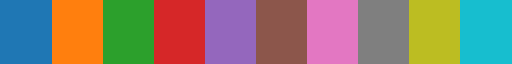

In [143]:
plt.cm.tab10

In [144]:
plt.cm.tab10.colors

((0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529))

# LOAD DATA

In [3]:
YEAR = 2019
DATE = f'{YEAR}0430'

dir_wofs = f"/ourdisk/hpc/ai2es/wofs/{YEAR}" #f"/ourdisk/hpc/ai2es/tornado/wofs-preds-{YEAR}" #2023

dir_wofs_preds = "/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jtti/wofs_preds"

TUNER = "tor_unet_sample50_50_classweightsNone_hyper"
MODEL = "2023_07_20_20_55_39_hp_model00"
#TUNER="tor_unet_sample50_50_classweights20_80_hyper"
#MODEL="2023_07_21_08_33_57_hp_model00"
#TUNER="tor_unet_sample50_50_classweights50_50_hyper"
#MODEL="2023_07_21_08_33_16_hp_model00"
TUNER="tor_unet_sample90_10_classweights20_80_hyper"
MODEL="2023_07_20_09_32_38_hp_model00"
dir_wofs_preds1 = f"/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jtti/wofs_preds1/{TUNER}"

dir_storm_reports = "/ourdisk/hpc/ai2es/alexnozka/tornado_reports" 

#TODO: IEM polygon storm warnings data

fn_wofs_test = "wrfwof_d01_2019-04-30_23:10:00_predictions.nc"

## LOAD STORM REPORTS

In [4]:
files_storm_reports = sorted(os.listdir(dir_storm_reports))
files_storm_reports

['190429_rpts_filtered_torn.csv',
 '190430_rpts_filtered_torn.csv',
 '190501_rpts_filtered_torn.csv',
 '190502_rpts_filtered_torn.csv',
 '190503_rpts_filtered_torn.csv',
 '190506_rpts_filtered_torn.csv',
 '190507_rpts_filtered_torn.csv',
 '190508_rpts_filtered_torn.csv',
 '190509_rpts_filtered_torn.csv',
 '190510_rpts_filtered_torn.csv',
 '190513_rpts_filtered_torn.csv',
 '190514_rpts_filtered_torn.csv',
 '190515_rpts_filtered_torn.csv',
 '190516_rpts_filtered_torn.csv']

In [5]:
storm_report_dates = [(2019, 4, 29),
                      (2019, 4, 30),
                      (2019, 5, 1),
                      (2019, 5, 2),
                      (2019, 5, 3),
                      (2019, 5, 6),
                      (2019, 5, 7),
                      (2019, 5, 8),
                      (2019, 5, 9),
                      (2019, 5, 10),
                      (2019, 5, 13),
                      (2019, 5, 14)]

In [6]:
fn_storm_report2 = os.path.join(dir_storm_reports, files_storm_reports[0])
#df_storm_report = pd.read_csv(fn_storm_report)
#df_storm_report
df_storm_report2, date_storm_report2 = wpe.load_storm_report(fn_storm_report2, YEAR, 
                                                             month=4, day=29)
df_storm_report2.shape, date_storm_report2

((0, 9), datetime.datetime(2019, 4, 29, 0, 0))

In [7]:
fn_storm_report2

'/ourdisk/hpc/ai2es/alexnozka/tornado_reports/190429_rpts_filtered_torn.csv'

In [8]:
fn_storm_report0 = os.path.join(dir_storm_reports, files_storm_reports[2])
#df_storm_report = pd.read_csv(fn_storm_report)
#df_storm_report
df_storm_report0, date_storm_report0 = wpe.load_storm_report(fn_storm_report0, YEAR, 
                                                             month=5, day=1)
df_storm_report0.shape, date_storm_report0

((9, 9), datetime.datetime(2019, 5, 1, 0, 0))

In [9]:
df_storm_report0

,Time,DateTime,F_Scale,Location,County,State,Lat,Lon,Comments
0,125,2019-05-01 01:25:00,UNK,10 NW GATESVILLE,CORYELL,TX,31.53,-97.87,SPOTTER REPORTED WEAK TORNADO 10 MILES NW OF G...
1,149,2019-05-01 01:49:00,UNK,1 E LONG LANE,DALLAS,MO,37.61,-92.89,NWS SURVEY CONFIRMED A BRIEF EF-1 TORNADO THAT...
2,1130,2019-05-01 11:30:00,UNK,7 NNW HUXLEY,SHELBY,TX,31.85,-93.95,THE TORNADO SNAPPED AND UPROOTED NUMEROUS TREE...
3,1140,2019-05-01 11:40:00,UNK,2 S STANLEY,DE SOTO,LA,31.93,-93.90,THE TORNADO SNAPPED AND UPROOTED NUMEROUS TREE...
4,1839,2019-05-01 18:39:00,UNK,11 N THROCKMORTON,THROCKMORTON,TX,33.32,-99.29,(SJT)
5,1903,2019-05-01 19:03:00,UNK,13 S SEYMOUR,BAYLOR,TX,33.41,-99.23,TORNADO WAS OBSERVED BY MULTIPLE STORM CHASERS...
6,1908,2019-05-01 19:08:00,UNK,8 SW LOCO,JEFFERSON,OK,34.26,-97.78,(OUN)
7,2125,2019-05-01 21:25:00,UNK,5 W MARIETTA,LOVE,OK,33.94,-97.20,(OUN)
8,2246,2019-05-01 22:46:00,UNK,13 NNE LUEDERS,HASKELL,TX,32.96,-99.51,BRIEF TORNADO. NO REPORTED DAMAGE. (SJT)


In [10]:
files_storm_reports[2]

'190501_rpts_filtered_torn.csv'

In [11]:
files_storm_reports[1]

'190430_rpts_filtered_torn.csv'

In [12]:
fn_storm_report = os.path.join(dir_storm_reports, files_storm_reports[1])
#df_storm_report = pd.read_csv(fn_storm_report)
#df_storm_report
df_storm_report, date_storm_report = wpe.load_storm_report(fn_storm_report, YEAR, 
                                                           month=4, day=30)
df_storm_report.shape, date_storm_report

((68, 9), datetime.datetime(2019, 4, 30, 0, 0))

In [13]:
all_dfs = []
for file, _date in zip(files_storm_reports, storm_report_dates):
    _df, date_storm_report = wpe.load_storm_report(fn_storm_report, YEAR,
                                                   month=_date[1], day=_date[2])
    all_dfs.append(_df)

df_storm_report = pd.concat(all_dfs, ignore_index=True, verify_integrity=True)

SAVE = False
if SAVE:
    df_storm_report.to_csv('/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jtti/tornado_reports/tornado_reports_2019_spring.csv', header=True)

df_storm_report.shape

(816, 9)

### df_storm_report

In [14]:
df_storm_report.head(12)

,Time,DateTime,F_Scale,Location,County,State,Lat,Lon,Comments
0,6,2019-04-29 00:06:00,UNK,5 WSW BRUSHYKNOB,DOUGLAS,MO,36.93,-92.57,NWS STORM SURVEY CONFIRMED AN EF-1 TORNADO WIT...
1,28,2019-04-29 00:28:00,UNK,2 N OZARK,CHRISTIAN,MO,37.07,-93.20,*** 3 INJ *** AN NWS STORM SURVEY CONFIRMED AN...
2,30,2019-04-29 00:30:00,UNK,4 WSW NORWOOD,WRIGHT,MO,37.10,-92.49,A NWS SURVEY TEAM CONFIRMED AN EF-1 TORNADO WH...
3,38,2019-04-29 00:38:00,UNK,6 NW MILLER,LAWRENCE,MO,37.29,-93.91,AN NWS STORM SURVEY CONFIRMED AN EF1 TORNADO T...
4,40,2019-04-29 00:40:00,UNK,1 SW EUDORA,POLK,MO,37.45,-93.56,AN NWS STORM SURVEY CONFIRMED AN EF1 TORNADO T...
5,58,2019-04-29 00:58:00,UNK,4 SW MOUNTAIN GROVE,WRIGHT,MO,37.09,-92.32,A NWS SURVEY TEAM CONFIRMED AN EF-0 TORNADO WH...
6,115,2019-04-29 01:15:00,UNK,2 NW WILLARD,GREENE,MO,37.33,-93.46,CORRECTS PREVIOUS TORNADO REPORT FROM 2 NW WIL...
7,121,2019-04-29 01:21:00,UNK,4 NE WILLARD,GREENE,MO,37.36,-93.39,AN NWS STORM SURVEY CONFIRMED AN EF1 TORNADO T...
8,124,2019-04-29 01:24:00,UNK,1 E ROGERSVILLE,WEBSTER,MO,37.11,-93.04,ROOF TORN OFF; PARTIAL BUILDING COLLAPSE ON EN...
9,128,2019-04-29 01:28:00,UNK,2 N OZARK,CHRISTIAN,MO,37.07,-93.20,*** 3 INJ *** CORRECTS PREVIOUS TORNADO REPORT...


In [15]:
df_storm_report.tail(12)

,Time,DateTime,F_Scale,Location,County,State,Lat,Lon,Comments
804,2118,2019-05-14 21:18:00,UNK,2 NNE BLUEJACKET,CRAIG,OK,36.83,-95.05,A TORNADO UPROOTED TREES (TSA)
805,2125,2019-05-14 21:25:00,UNK,4 WNW MCDOWELL,BARRY,MO,36.85,-93.85,CORRECTS PREVIOUS TORNADO REPORT FROM 4 WNW MC...
806,2127,2019-05-14 21:27:00,UNK,1 SE FLUVANNA,Scurry,TX,32.88,-101.14,TORNADO STAYED OVER OPEN FIELD...DISSIPATED AR...
807,2132,2019-05-14 21:32:00,UNK,2 E MIAMI,OTTAWA,OK,36.87,-94.84,RELAYED BY NWS EMPLOYEE (TSA)
808,2134,2019-05-14 21:34:00,UNK,4 NW DEAN,CLAY,TX,33.99,-98.40,STORM SPOTTER NOTIFICATIONS ON SOCIAL MEDIA. (...
809,2215,2019-05-14 22:15:00,UNK,2 WNW BRANSON,TANEY,MO,36.66,-93.26,TREE DAMAGE AND MINOR STRUCTURAL DAMAGE. PATH ...
810,2238,2019-05-14 22:38:00,UNK,3 SE AFTON,DELAWARE,OK,36.66,-94.92,PHOTOS RECEIVED OF A TORNADO SOUTHEAST OF AFTO...
811,2315,2019-05-14 23:15:00,UNK,5 W GOODHOPE,DOUGLAS,MO,36.90,-92.89,NWS STORM SURVEY CONFIRMED A TORNADO WEST OF G...
812,2325,2019-05-14 23:25:00,UNK,1.5 E JUSTIN,DENTON,TX,33.08,-97.28,DELAYED REPORT: STORM SURVEY TEAM CONFIRMED AN...
813,2344,2019-05-14 23:44:00,UNK,SQUIRES,DOUGLAS,MO,36.86,-92.62,A NWS SURVEY CONFIRMED AN EF-1 TORNADO THAT TR...


In [16]:
df_storm_report['DateTime'].tail(12)

804   2019-05-14 21:18:00
805   2019-05-14 21:25:00
806   2019-05-14 21:27:00
807   2019-05-14 21:32:00
808   2019-05-14 21:34:00
809   2019-05-14 22:15:00
810   2019-05-14 22:38:00
811   2019-05-14 23:15:00
812   2019-05-14 23:25:00
813   2019-05-14 23:44:00
814   2019-05-14 23:48:00
815   2019-05-14 23:56:00
Name: DateTime, dtype: datetime64[ns]

In [17]:
np.quantile(df_storm_report['Lat'], [0,1]), np.quantile(df_storm_report['Lon'], [0,1])

(array([32.88, 39.05]), array([-101.14,  -88.98]))

## LOAD WOFS PREDS

In [18]:
os.listdir(dir_wofs_preds)

['2019', '2018', '2023']

In [19]:
#WOFS_REL_PATH = f"{DATE}/{INIT_TIME}/ENS_MEM_{e}"
#_dir_preds = f"{DIR_PREDS}/{YEAR}/{WOFS_REL_PATH}"
_dirpreds = os.path.join(dir_wofs_preds, str(YEAR), DATE)
os.listdir(_dirpreds)

['2030',
 '2330',
 '2230',
 '0100',
 '2130',
 '2100',
 '0030',
 '2200',
 '0130',
 '0200',
 '1900',
 '1930',
 '0300',
 '2000',
 '0000',
 '0230',
 'wofs_preds_files.csv',
 '2300']

In [20]:
df_date_files = pd.read_csv(f'{_dirpreds}/wofs_preds_files.csv')
df_date_files.head()

,Unnamed: 0,run_date,init_time,ensemble_member,forecast_time,filename_path
0,13570,20190430,0,ENS_MEM_1,2019-05-01_00:00:00,/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
1,13560,20190430,0,ENS_MEM_1,2019-05-01_00:05:00,/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
2,13559,20190430,0,ENS_MEM_1,2019-05-01_00:10:00,/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
3,13610,20190430,0,ENS_MEM_1,2019-05-01_00:15:00,/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
4,13558,20190430,0,ENS_MEM_1,2019-05-01_00:20:00,/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...


In [21]:
df_date_files.columns

Index(['Unnamed: 0', 'run_date', 'init_time', 'ensemble_member', 'forecast_time', 'filename_path'], dtype='object')

In [22]:
df_date_files.head()

,Unnamed: 0,run_date,init_time,ensemble_member,forecast_time,filename_path
0,13570,20190430,0,ENS_MEM_1,2019-05-01_00:00:00,/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
1,13560,20190430,0,ENS_MEM_1,2019-05-01_00:05:00,/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
2,13559,20190430,0,ENS_MEM_1,2019-05-01_00:10:00,/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
3,13610,20190430,0,ENS_MEM_1,2019-05-01_00:15:00,/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
4,13558,20190430,0,ENS_MEM_1,2019-05-01_00:20:00,/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...


## ORGANIZE ENSEMBLES

In [23]:
#ens_names = glob.glob(os.path.join(_dirpreds, '1900', '*'))
ens_names = sorted(os.listdir(os.path.join(dir_wofs, DATE, '1900')))
ens_names, len(ens_names)

(['ENS_MEM_1',
  'ENS_MEM_10',
  'ENS_MEM_11',
  'ENS_MEM_12',
  'ENS_MEM_13',
  'ENS_MEM_14',
  'ENS_MEM_15',
  'ENS_MEM_16',
  'ENS_MEM_17',
  'ENS_MEM_18',
  'ENS_MEM_2',
  'ENS_MEM_3',
  'ENS_MEM_4',
  'ENS_MEM_5',
  'ENS_MEM_6',
  'ENS_MEM_7',
  'ENS_MEM_8',
  'ENS_MEM_9'],
 18)

In [24]:
_l = glob.glob(os.path.join(_dirpreds, '1900', '*', '*'))
len(_l)

1350

In [25]:
_l[:4]

['/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jtti/wofs_preds/2019/20190430/1900/ENS_MEM_17/wrfwof_d01_2019-04-30_21:35:00_predictions.nc',
 '/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jtti/wofs_preds/2019/20190430/1900/ENS_MEM_17/wrfwof_d01_2019-04-30_22:50:00_predictions.nc',
 '/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jtti/wofs_preds/2019/20190430/1900/ENS_MEM_17/wrfwof_d01_2019-05-01_00:20:00_predictions.nc',
 '/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jtti/wofs_preds/2019/20190430/1900/ENS_MEM_17/wrfwof_d01_2019-04-30_20:30:00_predictions.nc']

In [26]:
fmt_dt = '%Y-%m-%d_%H:%M:%S' #'%Y-%m-%d_%H_%M_%S' '%Y-%m-%d_%H_%M_%S'
fmt_re = r'\d{4}-\d{2}-\d{2}_\d{2}(_|:)\d{2}(_|:)\d{2}' #r'\d{4}-\d{2}-\d{2}_\d{2}_\d{2}_\d{2}'

extr_args = {'method': 're', 'fmt_dt': fmt_dt, 'fmt_re': fmt_re}

init_time = '1900'
_dir = os.path.join(dir_wofs_preds, str(YEAR))
save_path = None #os.path.join(save_path, 'wofs_preds_files.csv')
df_files_ens9 = wpe.generate_ensemble_files_list(_dir, DATE, init_time, 
                                                 'ENS_MEM_9', 
                                                 save_path=save_path, 
                                                 **extr_args)

df_all_files = wpe.generate_ensemble_files_list_all(_dir, DATE, init_time, 
                                                    ens_names=[], 
                                                    save_path=save_path, 
                                                    df_index=False, **extr_args)

print(df_all_files.shape)
df_all_files.head(12)

(1350, 5)


,run_date,init_time,ensemble_member,forecast_time,filename_path
0,20190430,1900,ENS_MEM_1,2019-04-30_19:00:00,/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
1,20190430,1900,ENS_MEM_1,2019-04-30_19:00:00,/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
2,20190430,1900,ENS_MEM_1,2019-04-30_19:05:00,/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
3,20190430,1900,ENS_MEM_1,2019-04-30_19:10:00,/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
4,20190430,1900,ENS_MEM_1,2019-04-30_19:15:00,/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
5,20190430,1900,ENS_MEM_1,2019-04-30_19:20:00,/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
6,20190430,1900,ENS_MEM_1,2019-04-30_19:25:00,/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
7,20190430,1900,ENS_MEM_1,2019-04-30_19:30:00,/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
8,20190430,1900,ENS_MEM_1,2019-04-30_19:35:00,/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
9,20190430,1900,ENS_MEM_1,2019-04-30_19:40:00,/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...


In [27]:
df_all_files['filename_path'].iloc[:4].values

array(['/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jtti/wofs_preds/2019/20190430/1900/ENS_MEM_1/wrfout_d01_2019-04-30_19:00:00_predictions.nc',
       '/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jtti/wofs_preds/2019/20190430/1900/ENS_MEM_1/wrfwof_d01_2019-04-30_19:00:00_predictions.nc',
       '/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jtti/wofs_preds/2019/20190430/1900/ENS_MEM_1/wrfwof_d01_2019-04-30_19:05:00_predictions.nc',
       '/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jtti/wofs_preds/2019/20190430/1900/ENS_MEM_1/wrfwof_d01_2019-04-30_19:10:00_predictions.nc'],
      dtype=object)

In [28]:
ftime = '2019-04-30_19:05:00'
_files = select_files(df_all_files, init_time, ftime, emember=None)
_files.shape

(18, 5)

In [29]:
_files.head()

,run_date,init_time,ensemble_member,forecast_time,filename_path
2,20190430,1900,ENS_MEM_1,2019-04-30_19:05:00,/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
77,20190430,1900,ENS_MEM_10,2019-04-30_19:05:00,/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
152,20190430,1900,ENS_MEM_11,2019-04-30_19:05:00,/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
227,20190430,1900,ENS_MEM_12,2019-04-30_19:05:00,/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
302,20190430,1900,ENS_MEM_13,2019-04-30_19:05:00,/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...


In [30]:
pd.unique(_files['forecast_time']), pd.unique(_files['ensemble_member'])

(array(['2019-04-30_19:05:00'], dtype=object),
 array(['ENS_MEM_1', 'ENS_MEM_10', 'ENS_MEM_11', 'ENS_MEM_12',
        'ENS_MEM_13', 'ENS_MEM_14', 'ENS_MEM_15', 'ENS_MEM_16',
        'ENS_MEM_17', 'ENS_MEM_18', 'ENS_MEM_2', 'ENS_MEM_3', 'ENS_MEM_4',
        'ENS_MEM_5', 'ENS_MEM_6', 'ENS_MEM_7', 'ENS_MEM_8', 'ENS_MEM_9'],
       dtype=object))

In [31]:
_files = select_files(df_all_files, init_time, None, emember='ENS_MEM_14')
_files.shape

(75, 5)

In [32]:
pd.unique(_files['ensemble_member'])

array(['ENS_MEM_14'], dtype=object)

In [33]:
pd.unique(_files['forecast_time'])

array(['2019-04-30_19:00:00', '2019-04-30_19:05:00',
       '2019-04-30_19:10:00', '2019-04-30_19:15:00',
       '2019-04-30_19:20:00', '2019-04-30_19:25:00',
       '2019-04-30_19:30:00', '2019-04-30_19:35:00',
       '2019-04-30_19:40:00', '2019-04-30_19:45:00',
       '2019-04-30_19:50:00', '2019-04-30_19:55:00',
       '2019-04-30_20:00:00', '2019-04-30_20:05:00',
       '2019-04-30_20:10:00', '2019-04-30_20:15:00',
       '2019-04-30_20:20:00', '2019-04-30_20:25:00',
       '2019-04-30_20:30:00', '2019-04-30_20:35:00',
       '2019-04-30_20:40:00', '2019-04-30_20:45:00',
       '2019-04-30_20:50:00', '2019-04-30_20:55:00',
       '2019-04-30_21:00:00', '2019-04-30_21:05:00',
       '2019-04-30_21:10:00', '2019-04-30_21:15:00',
       '2019-04-30_21:20:00', '2019-04-30_21:25:00',
       '2019-04-30_21:30:00', '2019-04-30_21:35:00',
       '2019-04-30_21:40:00', '2019-04-30_21:45:00',
       '2019-04-30_21:50:00', '2019-04-30_21:55:00',
       '2019-04-30_22:00:00', '2019-04-30_22:0

In [34]:
df_files_ens9.dtypes['init_time'], type(df_files_ens9['init_time'][0]), df_files_ens9['init_time'][0]

(dtype('O'), str, '1900')

In [35]:
ty = type(df_files_ens9['init_time'][0])
ty(1990)

'1990'

In [36]:
df_files_ens9.shape, df_files_ens9['filename_path'].iloc[:4].values

((75, 5),
 array(['/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jtti/wofs_preds/2019/20190430/1900/ENS_MEM_9/wrfout_d01_2019-04-30_19:00:00_predictions.nc',
        '/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jtti/wofs_preds/2019/20190430/1900/ENS_MEM_9/wrfwof_d01_2019-04-30_19:00:00_predictions.nc',
        '/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jtti/wofs_preds/2019/20190430/1900/ENS_MEM_9/wrfwof_d01_2019-04-30_19:05:00_predictions.nc',
        '/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jtti/wofs_preds/2019/20190430/1900/ENS_MEM_9/wrfwof_d01_2019-04-30_19:10:00_predictions.nc'],
       dtype=object))

In [37]:
df_files_ens9.head(6)

,run_date,init_time,ensemble_member,forecast_time,filename_path
0,20190430,1900,ENS_MEM_9,2019-04-30_19:00:00,/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
2,20190430,1900,ENS_MEM_9,2019-04-30_19:00:00,/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
3,20190430,1900,ENS_MEM_9,2019-04-30_19:05:00,/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
4,20190430,1900,ENS_MEM_9,2019-04-30_19:10:00,/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
5,20190430,1900,ENS_MEM_9,2019-04-30_19:15:00,/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
6,20190430,1900,ENS_MEM_9,2019-04-30_19:20:00,/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...


In [38]:
# merge ensembles into dataset for single forecast time
ftime = '2019-04-30_19:05:00'
sel_files_ftime = select_files(df_all_files, init_time, ftime, emember=None)
print(sel_files_ftime.shape)

concat_dim = 'ENS'
_sel_files = list(sel_files_ftime['filename_path'])
wofs_preds = xr.open_mfdataset(_sel_files, concat_dim=concat_dim,
                               combine='nested', decode_times=False)
print(wofs_preds['Time'])
_dtime = num2date(wofs_preds.Time, 'seconds since 2001-01-01')
print("DateTime", _dtime)
wofs_preds.drop_vars('Time')

stat = 'median'
wofs_cZH = {stat: None}
wofs_prob = {stat: None}
wofs_uh = {stat: None}

if stat == 'median':
    wofs_cZH[stat] = wofs_preds['COMPOSITE_REFL_10CM'].median(dim=concat_dim).values[0]
    wofs_prob[stat] = wofs_preds['ML_PREDICTED_TOR'].median(dim=concat_dim).values[0]
    wofs_uh[stat] = wofs_preds['UP_HELI_MAX'].median(dim=concat_dim).values[0]
#getattr(my_instance, method_name)() 'UP_HELI_MAX'
elif stat == 'mean':
    wofs_cZH[stat] = wofs_preds['COMPOSITE_REFL_10CM'].mean(dim=concat_dim).values[0]
    wofs_prob[stat] = wofs_preds['ML_PREDICTED_TOR'].mean(dim=concat_dim).values[0]
    wofs_uh[stat] = wofs_preds['UP_HELI_MAX'].mean(dim=concat_dim).values[0]

#year, date, init, ens, ftime: ml_preds, storm_mask, uh_mask

(18, 5)


<xarray.DataArray 'Time' (Time: 1)>
array([578343900])
Coordinates:
  * Time     (Time) int64 578343900
DateTime [cftime.DatetimeGregorian(2019, 4, 30, 19, 5, 0, 0, has_year_zero=False)]


In [39]:
from scipy.ndimage import grey_dilation

In [40]:
# Dialated Probab
ksize = 33 #17
prob_dialated = grey_dilation(wofs_prob[stat], size=(ksize, ksize)) #, footprint=None, structure=None, output=None, mode='reflect', cval=0.0, origin=0)

Qs = [0, .5, .75, .9, .95, 1]

print(np.quantile(wofs_prob[stat], Qs))
print(np.quantile(prob_dialated, Qs))

[0.00000000e+00 4.77335116e-07 9.02878401e-06 5.77881891e-05
 2.15243258e-04 6.43495717e-01]
[2.44254785e-04 1.65265370e-03 5.98383152e-03 3.56835477e-02
 1.47270391e-01 6.43495717e-01]


Text(0.5, 1.0, '[median] Dilated')

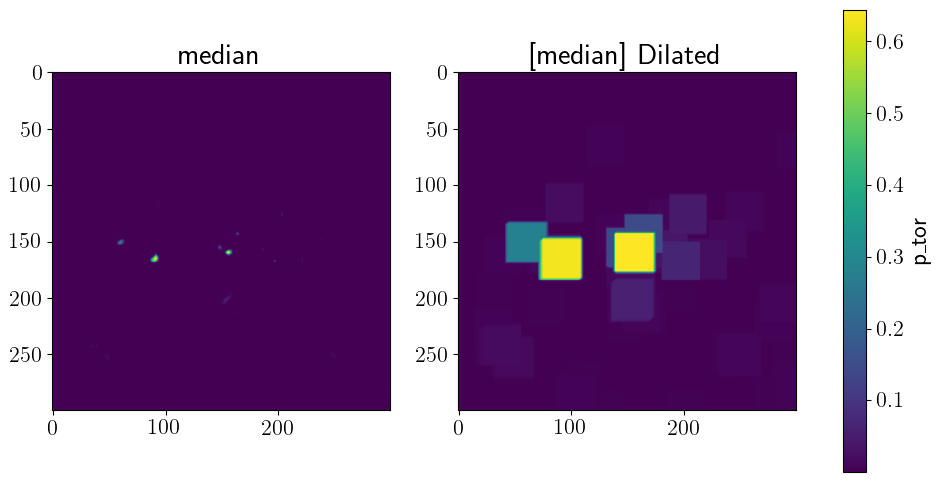

In [41]:
f_, a_ = plt.subplots(1, 2, figsize=(12, 6))
a_.ravel()

im = a_[0].imshow(wofs_prob[stat]) #, cmap='civiridis')
#plt.colorbar(im, ax=a_, label=r'p_{tor}')
a_[0].set_title(stat)

# Dialated Probab                             
im = a_[1].imshow(prob_dialated) #, cmap='civiridis')
plt.colorbar(im, ax=a_, label=r'p_{tor}')
a_[1].set_title(f'[{stat}] Dilated')

## load ...

In [42]:
#fnpath_all_ens = os.path.join(_dirpreds, '1900', 'ENS_MEM_1', '*')
_list = df_all_files['filename_path'].values
xrload_args = {'combine': 'nested', #'concat_dim': 'forecast', 
               'decode_times': False, 'engine': 'netcdf4'}
wofs_test = xr.open_mfdataset(_list[:10], **xrload_args)

In [43]:
wofs_test.coords

Mixed precision float32 <dtype: 'float32'>
 


Coordinates:
  * Time     (Time) int64 578343600 578343900 578344200 ... 578345700 578346000
    XLAT     (Time, south_north, west_east) float32 dask.array<chunksize=(9, 300, 300), meta=np.ndarray>
    XLONG    (Time, south_north, west_east) float32 dask.array<chunksize=(9, 300, 300), meta=np.ndarray>
    XLAT_U   (Time, south_north, west_east_stag) float32 dask.array<chunksize=(9, 300, 301), meta=np.ndarray>
    XLAT_V   (Time, south_north_stag, west_east) float32 dask.array<chunksize=(9, 301, 300), meta=np.ndarray>
    XLONG_U  (Time, south_north, west_east_stag) float32 dask.array<chunksize=(9, 300, 301), meta=np.ndarray>
    XLONG_V  (Time, south_north_stag, west_east) float32 dask.array<chunksize=(9, 301, 300), meta=np.ndarray>
    XTIME    (Time) float32 dask.array<chunksize=(9,), meta=np.ndarray>

In [44]:
wofs_test.dims

Frozen({'Time': 9, 'south_north': 300, 'west_east': 300, 'bottom_top': 50, 'south_north_stag': 301, 'west_east_stag': 301, 'bottom_top_stag': 51})

In [45]:
wofs_test.attrs

{'TITLE': ' OUTPUT FROM WRF V3.8 MODEL',
 'START_DATE': '2019-04-30_19:00:00',
 'SIMULATION_START_DATE': '2019-04-30_19:00:00',
 'WEST-EAST_GRID_DIMENSION': 301,
 'SOUTH-NORTH_GRID_DIMENSION': 301,
 'BOTTOM-TOP_GRID_DIMENSION': 51,
 'DX': 3000.0,
 'DY': 3000.0,
 'SKEBS_ON': 0,
 'SPEC_BDY_FINAL_MU': 0,
 'USE_Q_DIABATIC': 0,
 'GRIDTYPE': 'C',
 'DIFF_OPT': 1,
 'KM_OPT': 4,
 'DAMP_OPT': 3,
 'DAMPCOEF': 0.2,
 'KHDIF': 0.0,
 'KVDIF': 0.0,
 'MP_PHYSICS': 18,
 'RA_LW_PHYSICS': 1,
 'RA_SW_PHYSICS': 1,
 'SF_SFCLAY_PHYSICS': 1,
 'SF_SURFACE_PHYSICS': 3,
 'BL_PBL_PHYSICS': 1,
 'CU_PHYSICS': 0,
 'SF_LAKE_PHYSICS': 0,
 'SURFACE_INPUT_SOURCE': 1,
 'SST_UPDATE': 0,
 'GRID_FDDA': 0,
 'GFDDA_INTERVAL_M': 0,
 'GFDDA_END_H': 0,
 'GRID_SFDDA': 0,
 'SGFDDA_INTERVAL_M': 0,
 'SGFDDA_END_H': 0,
 'HYPSOMETRIC_OPT': 2,
 'USE_THETA_M': 0,
 'SF_URBAN_PHYSICS': 0,
 'SHCU_PHYSICS': 0,
 'MFSHCONV': 0,
 'FEEDBACK': 0,
 'SMOOTH_OPTION': 0,
 'SWRAD_SCAT': 1.0,
 'W_DAMPING': 1,
 'RADT': 5.0,
 'BLDT': 0.0,
 'CUDT': 0.0,
 

In [46]:
wofs_test.data_vars

Data variables:
    ML_PREDICTED_TOR     (Time, south_north, west_east) float64 dask.array<chunksize=(9, 300, 300), meta=np.ndarray>
    Times                (Time) object dask.array<chunksize=(9,), meta=np.ndarray>
    V                    (Time, bottom_top, south_north_stag, west_east) float32 dask.array<chunksize=(9, 50, 301, 300), meta=np.ndarray>
    U                    (Time, bottom_top, south_north, west_east_stag) float32 dask.array<chunksize=(9, 50, 300, 301), meta=np.ndarray>
    UP_HELI_MAX          (Time, south_north, west_east) float32 dask.array<chunksize=(9, 300, 300), meta=np.ndarray>
    PB                   (Time, bottom_top, south_north, west_east) float32 dask.array<chunksize=(9, 50, 300, 300), meta=np.ndarray>
    PH                   (Time, bottom_top_stag, south_north, west_east) float32 dask.array<chunksize=(9, 51, 300, 300), meta=np.ndarray>
    HGT                  (Time, south_north, west_east) float32 dask.array<chunksize=(9, 300, 300), meta=np.ndarray>
   

In [47]:
'''
wofs_test.attrs['FORECAST_DATETIME']
wofs_test.START_DATE

datetime_forecast_str = wofs.Times.data[0].decode('ascii') # decode from binary str to regular text str
datetime_forecast = datetime.fromisoformat(datetime_forecast_str)
datetime_init = datetime.fromisoformat(wofs.START_DATE) 

datetime_int = num2date(wofs.time.values[0], seconds_since) #
forecast_time = np.datetime64(datetime_int)
'''
wofs_test.Times.values

array([b'2019-04-30_19:00:00', b'2019-04-30_19:05:00',
       b'2019-04-30_19:10:00', b'2019-04-30_19:15:00',
       b'2019-04-30_19:20:00', b'2019-04-30_19:25:00',
       b'2019-04-30_19:30:00', b'2019-04-30_19:35:00',
       b'2019-04-30_19:40:00'], dtype=object)

In [48]:
# Decode from binary string to text
[t.decode('ascii') for t in wofs_test.Times.values]
#wofs_test.Times.values[0].decode('ascii')

['2019-04-30_19:00:00',
 '2019-04-30_19:05:00',
 '2019-04-30_19:10:00',
 '2019-04-30_19:15:00',
 '2019-04-30_19:20:00',
 '2019-04-30_19:25:00',
 '2019-04-30_19:30:00',
 '2019-04-30_19:35:00',
 '2019-04-30_19:40:00']

In [49]:
wofs_test = wofs_test.sortby("Time") 
wofs_test.Time

<xarray.DataArray 'Time' (Time: 9)>
array([578343600, 578343900, 578344200, 578344500, 578344800, 578345100,
       578345400, 578345700, 578346000])
Coordinates:
  * Time     (Time) int64 578343600 578343900 578344200 ... 578345700 578346000
    XTIME    (Time) float32 dask.array<chunksize=(9,), meta=np.ndarray>

In [50]:
dt_objs = num2date(wofs_test.Time, 'seconds since 2001-01-01')
dt_objs

array([cftime.DatetimeGregorian(2019, 4, 30, 19, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2019, 4, 30, 19, 5, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2019, 4, 30, 19, 10, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2019, 4, 30, 19, 15, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2019, 4, 30, 19, 20, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2019, 4, 30, 19, 25, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2019, 4, 30, 19, 30, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2019, 4, 30, 19, 35, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2019, 4, 30, 19, 40, 0, 0, has_year_zero=False)],
      dtype=object)

In [51]:
dt_objs[1] - dt_objs[0]

datetime.timedelta(seconds=300)

In [52]:
forecast_times = [np.datetime64(d) for d in dt_objs]
forecast_times

[numpy.datetime64('2019-04-30T19:00:00.000000'),
 numpy.datetime64('2019-04-30T19:05:00.000000'),
 numpy.datetime64('2019-04-30T19:10:00.000000'),
 numpy.datetime64('2019-04-30T19:15:00.000000'),
 numpy.datetime64('2019-04-30T19:20:00.000000'),
 numpy.datetime64('2019-04-30T19:25:00.000000'),
 numpy.datetime64('2019-04-30T19:30:00.000000'),
 numpy.datetime64('2019-04-30T19:35:00.000000'),
 numpy.datetime64('2019-04-30T19:40:00.000000')]

In [53]:
forecast_times[1] - forecast_times[0]

numpy.timedelta64(300000000,'us')

In [54]:
np.quantile(wofs_test['XLAT'].values, [0,1]), np.quantile(wofs_test['XLONG'].values, [0,1])

(array([31.894531, 40.25494 ], dtype=float32),
 array([-101.79907,  -90.91565], dtype=float32))

In [55]:
np.quantile(wofs_test['XLAT'].values, [0,1]), np.quantile(wofs_test['XLONG'].values, [0,1])

(array([31.894531, 40.25494 ], dtype=float32),
 array([-101.79907,  -90.91565], dtype=float32))

In [56]:
wofs_test['XLAT'].values[:2, :4, :4]

array([[[31.894531, 31.896152, 31.89777 , 31.89936 ],
        [31.92168 , 31.923302, 31.924911, 31.926517],
        [31.948833, 31.95045 , 31.952065, 31.953663],
        [31.975983, 31.977608, 31.979221, 31.980824]],

       [[31.894531, 31.896152, 31.89777 , 31.89936 ],
        [31.92168 , 31.923302, 31.924911, 31.926517],
        [31.948833, 31.95045 , 31.952065, 31.953663],
        [31.975983, 31.977608, 31.979221, 31.980824]]], dtype=float32)

In [57]:
np.diff(wofs_test['XLAT'].values[:2, :4, :4], n=1, axis=1)

array([[[0.0271492 , 0.0271492 , 0.02714157, 0.02715683],
        [0.02715302, 0.0271492 , 0.02715302, 0.02714539],
        [0.0271492 , 0.02715683, 0.02715683, 0.02716064]],

       [[0.0271492 , 0.0271492 , 0.02714157, 0.02715683],
        [0.02715302, 0.0271492 , 0.02715302, 0.02714539],
        [0.0271492 , 0.02715683, 0.02715683, 0.02716064]]], dtype=float32)

In [58]:
diffs_xlat = np.diff(wofs_test['XLAT'].values[0, :4, :4], n=1, axis=0)
diffs_xlat.mean()

0.027151743

In [59]:
wofs_test['XLONG'].values[:2, :4, :4]

array([[[-101.14868 , -101.1167  , -101.08475 , -101.052765],
        [-101.150604, -101.11862 , -101.08664 , -101.05463 ],
        [-101.15253 , -101.120514, -101.08853 , -101.05652 ],
        [-101.15445 , -101.12244 , -101.09042 , -101.05841 ]],

       [[-101.14868 , -101.1167  , -101.08475 , -101.052765],
        [-101.150604, -101.11862 , -101.08664 , -101.05463 ],
        [-101.15253 , -101.120514, -101.08853 , -101.05652 ],
        [-101.15445 , -101.12244 , -101.09042 , -101.05841 ]]],
      dtype=float32)

In [60]:
np.diff(wofs_test['XLONG'].values[:2, :4, :4], n=1, axis=2)

array([[[0.03198242, 0.0319519 , 0.03198242],
        [0.03198242, 0.03198242, 0.03201294],
        [0.03201294, 0.03198242, 0.03201294],
        [0.03201294, 0.03201294, 0.03201294]],

       [[0.03198242, 0.0319519 , 0.03198242],
        [0.03198242, 0.03198242, 0.03201294],
        [0.03201294, 0.03198242, 0.03201294],
        [0.03201294, 0.03201294, 0.03201294]]], dtype=float32)

In [61]:
diffs_xlons = np.diff(wofs_test['XLONG'].values[:2, :4, :4], n=1, axis=2)
diffs_xlons.mean()

0.031995136

In [62]:
diffs_xlons = np.diff(wofs_test['XLONG'].values[0, :4, :4], n=1, axis=1)
diffs_xlons.mean()

0.031995136

# GENERATE STORM REPORT MASKS

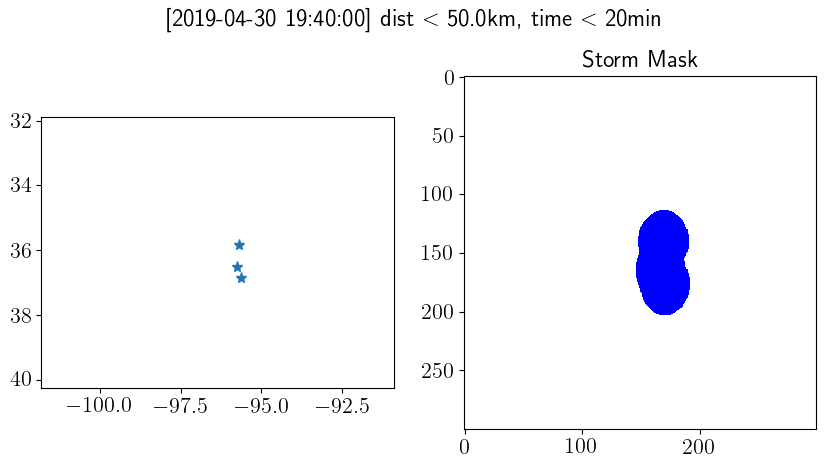

In [63]:
GRIDSIZE = 3 # km
thres_dist = 50. # km
thres_time = 20 # min

# WoFS Space
ti = 8
xlats = wofs_test['XLAT'].values[ti]
xlons = wofs_test['XLONG'].values[ti]
dt_objs = num2date(wofs_test.Time, 'seconds since 2001-01-01')
dtime = dt_objs[ti]

# Storm Reports
lats_storm = df_storm_report['Lat'].values 
lons_storm = df_storm_report['Lon'].values
times_storms = np.array([d.to_pydatetime() for d in pd.to_datetime(df_storm_report['DateTime'].values)])
#pd.to_datetime(df_storm_report['DateTime'])[0].to_pydatetime()

mask, sel_storms, tree = wpe.create_storm_mask(xlats, xlons, dtime, lats_storm, 
                                               lons_storm, times_storms, GRIDSIZE, 
                                               thres_dist=thres_dist, 
                                               thres_time=thres_time, kdworkers=-1)

ylims = np.quantile(wofs_test['XLAT'].values, [0, 1])
xlims = np.quantile(wofs_test['XLONG'].values, [0, 1])

figax_storms = wpe.plot_storms(mask, lons_storm[sel_storms], lats_storm[sel_storms], 
                               figax=None, figsize=(10, 5), xlims=xlims, ylims=ylims, 
                               invert_yaxis=True, 
                               bcmap=mpl.colors.ListedColormap(['w', 'blue']))
figax_storms[0].suptitle(rf'[{dtime}] dist $<$ {thres_dist}km, time $<$ {thres_time}min');

 n fig axes 6


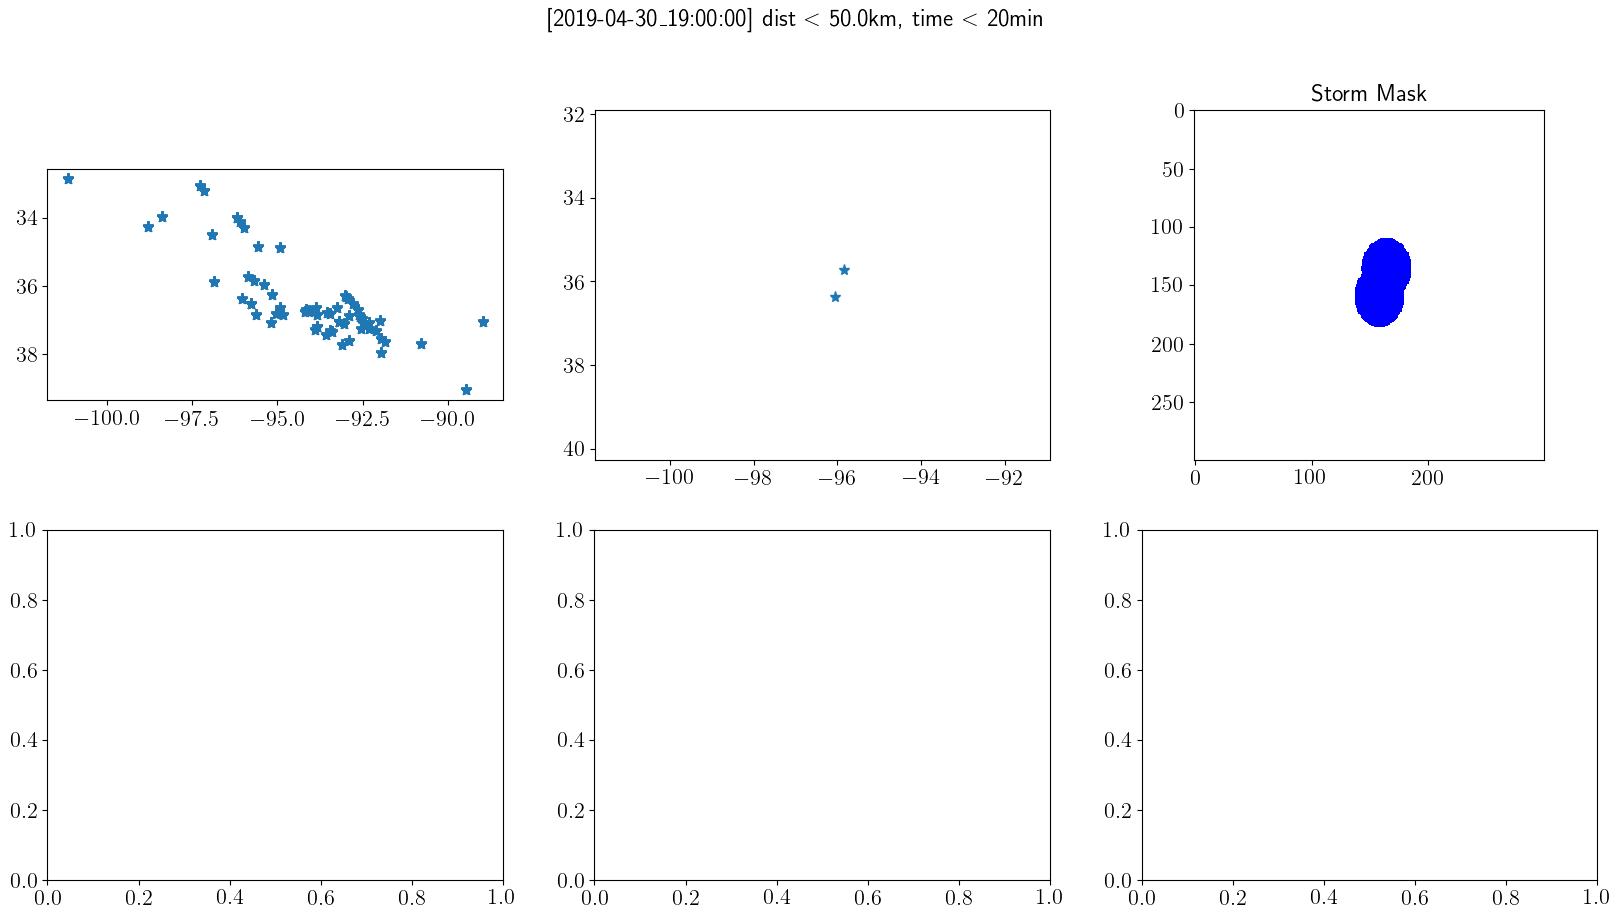

In [64]:
# TODO: gif of storm report masks
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib import ticker

def create_storms_gif(df_all_files,
    lats_storm, lons_storm, times_storms, gridsize, 
    thres_dist=thres_dist, 
    thres_time=thres_time, invert_yaxis=False, figsize=(20, 10), 
    nframes=None, interval=50, **kwargs):

    '''
    data, data_contours, fnpath, data_uh=None, stat="", frame_labels=None, 
               nframes=None, interval=50, figsize=(20, 10), dpi=250, 
               tight=False, DB=0, write=False, **kwargs):
    '''
    ''' 
    Create a .gif or movie file of the storm data
    matplotlib documentation 
    https://www.c-sharpcorner.com/article/create-animated-gif-using-python-matplotlib/

    '''
    #from matplotlib.animation import FuncAnimation, PillowWriter
    #import imageio
    fig = None
    axs = None
    fig, axs = plt.subplots(2, 3, figsize=figsize)
    axs = axs.ravel()

    # Plot all storm reports
    axs[0].plot(lons_storm, lats_storm, '*', ms=8)
    axs[0].set_aspect('equal')
    if invert_yaxis:
        axs[0].invert_yaxis()


    def draw_storm_frame(pi):
        '''
        Draw a patch as a single frame
        @param pi: patch index (aka draw frame index)
        '''
        if isinstance(axs, list) or isinstance(axs, np.ndarray):
            for a in axs[1:]: a.clear()
        else: axs.clear()

        all_ftimes = df_all_files['forecast_time'].values
        n_all_ftimes = all_ftimes.size
        ftimes = np.unique(all_ftimes)
        sel_files_by_ftime = select_files(df_all_files, '1900', #TODO: args.init_time, 
                                          ftimes[pi], emember=None)

        # Load all ensembles for the forecast time
        concat_dim = 'ENS'
        _sel_fnpaths = sel_files_by_ftime['filename_path'].values
        wofs_preds = xr.open_mfdataset(_sel_fnpaths, concat_dim=concat_dim,
                                        combine='nested', coords='minimal',
                                        decode_times=False)
        dtime = num2date(wofs_preds.Time[0], 'seconds since 2001-01-01')
        wofs_preds.drop_vars('Time')

        xlats = wofs_preds['XLAT'].values[0]
        xlons = wofs_preds['XLONG'].values[0]

        ylims = np.quantile(xlats, [0, 1])
        xlims = np.quantile(xlons, [0, 1])

        # COMPUTE MEAN/MEDIAN
        stat = 'mean'
        if stat == 'mean':
            # Use [0] to remove the singleton dimension
            wofs_cZH[ftime] = wofs_preds['COMPOSITE_REFL_10CM'].mean(dim=concat_dim).values[0]
            wofs_prob[ftime] = wofs_preds['ML_PREDICTED_TOR'].mean(dim=concat_dim).values[0]
            wofs_uh[ftime] = wofs_preds['UP_HELI_MAX'].mean(dim=concat_dim).values[0]
        elif stat == 'median':
            wofs_cZH[ftime] = wofs_preds['COMPOSITE_REFL_10CM'].median(dim=concat_dim).values[0]
            wofs_prob[ftime] = wofs_preds['ML_PREDICTED_TOR'].median(dim=concat_dim).values[0]
            wofs_uh[ftime] = wofs_preds['UP_HELI_MAX'].median(dim=concat_dim).values[0]

        mask, sel_storms, _ = wpe.create_storm_mask(xlats, xlons, dtime, #ftimes[pi], 
                                                            lats_storm, lons_storm, 
                                                            times_storms, 
                                                            gridsize, 
                                                            thres_dist=thres_dist, 
                                                            thres_time=thres_time, 
                                                            kdworkers=-1)

        _ = wpe.plot_storms(mask, lons_storm[sel_storms], lats_storm[sel_storms], 
                                    figax=(fig, axs[1:3]), figsize=(10, 5), 
                                    xlims=xlims, ylims=ylims, 
                                    invert_yaxis=invert_yaxis, 
                                    bcmap=mpl.colors.ListedColormap(['w', 'blue']))
        fig.suptitle(rf'[{ftimes[pi]}] dist $<$ {thres_dist}km, time $<$ {thres_time}min')

        fig.canvas.draw() # draw the canvas, cache renderer
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        WIDTH, HEIGHT = fig.canvas.get_width_height()
        image = image.reshape(HEIGHT, WIDTH, 3) # 3 for RGB
        return image

    #fname = os.path.basename(wofs.filenamepath) + f'__{suffix}.gif'

    # Plot first frame ot get colorbar to render properly
    #ZH_distr, ax = plotter(data[0], data_contours[0], title, 0, axs[0], cmap="Spectral_r", vmin=vmin, vmax=vmax)
    #draw_storm_frame(0)

    animator = FuncAnimation(fig, draw_storm_frame, frames=nframes, 
                             interval=interval, **kwargs)
    print(" n fig axes", len(fig.axes)) #fig.delaxes(fig.axes[-1])

    return fig, animator


ftimes = np.unique(df_all_files['forecast_time'].values)
n_ftimes = np.unique(ftimes).size

#plt.rcParams["animation.html"] = "jshtml"

fig, ani = create_storms_gif(df_all_files, lats_storm, 
    lons_storm, times_storms, GRIDSIZE, 
    thres_dist=thres_dist, thres_time=thres_time, 
    invert_yaxis=True, figsize=(20, 10), 
    nframes=n_ftimes, interval=1000) #, **kwargs) #interval delay in milliseconds

#ani.save('_storm_reports.gif', dpi=200) #, writer=writer)

xr version 2023.8.0
np version 1.24.2
pd version 1.5.3


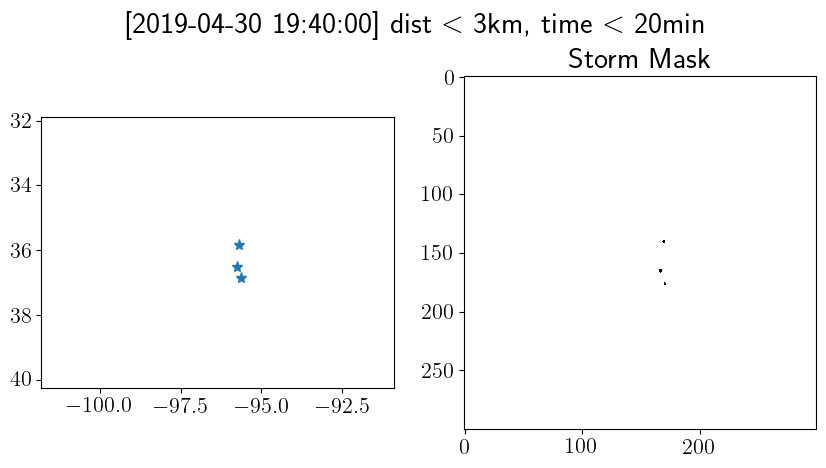

In [65]:
mask_, sel_, tree_ = wpe.create_storm_mask(xlats, xlons, dtime, lats_storm, 
                                           lons_storm, times_storms, 
                                           GRIDSIZE, thres_dist=3, 
                                           thres_time=thres_time, kdworkers=-1)

ylims = np.quantile(wofs_test['XLAT'].values, [0, 1])
xlims = np.quantile(wofs_test['XLONG'].values, [0, 1])

figax_storms = wpe.plot_storms(mask_, lons_storm[sel_], lats_storm[sel_], 
                               figax=None, figsize=(10, 5), xlims=xlims, 
                               ylims=ylims, invert_yaxis=True, 
                               bcmap=mpl.colors.ListedColormap(['w', 'k']))
figax_storms[0].suptitle(rf'[{dtime}] dist $<$ 3km, time $<$ {thres_time}min');

Text(0.5, 0.98, '[2019-04-30 19:40:00] dist $<$ 10km, time $<$ 20min')

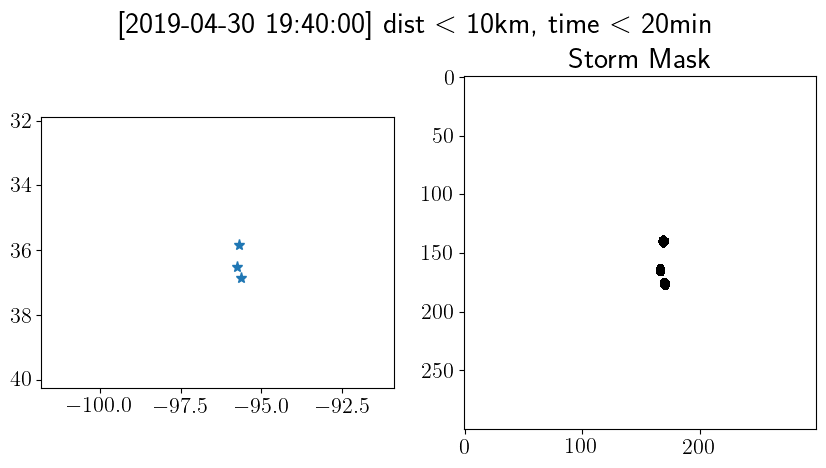

In [66]:
mask_, sel_, tree_ = wpe.create_storm_mask(xlats, xlons, dtime, lats_storm, lons_storm, 
                                    times_storms, GRIDSIZE, thres_dist=10, 
                                    thres_time=thres_time, kdworkers=-1)

figax_storms = wpe.plot_storms(mask_, lons_storm[sel_], lats_storm[sel_], 
                               figax=None, figsize=(10, 5), xlims=xlims, 
                               ylims=ylims, invert_yaxis=True, 
                               bcmap=mpl.colors.ListedColormap(['w', 'k']))
figax_storms[0].suptitle(rf'[{dtime}] dist $<$ 10km, time $<$ {thres_time}min')

# GENERATE UH MASKS

In [67]:
def create_uh_mask(uh, thres_uh=50, quantile=False):
    """ 
    Create masks from UH
    Parameters
    ----------
    uh:
    thres_uh: greater than 
    quantile: bool. whether thres_uh is a quantile between 0 and 1
    """
    if quantile:
        thres_uh = np.quantile(uh, thres_uh)

    mask = uh > thres_uh
    return mask, thres_uh

thres_uh_Q = .98
QUANTILE = True

print(ti)
print(wofs_test['UP_HELI_MAX'].shape)
uh = wofs_test['UP_HELI_MAX'].values[ti]

mask_uh, uh_thres = create_uh_mask(uh, thres_uh=thres_uh_Q, quantile=QUANTILE)

8
(9, 300, 300)


In [68]:
uh.shape

(300, 300)

In [69]:
np.nanquantile(wofs_test['UP_HELI_MAX'], [0, thres_uh_Q, 1])

array([  0.        ,   0.5842334 , 113.18749237])

In [70]:
np.nanquantile(wofs_test['UP_HELI_MAX'][ti], [0, thres_uh_Q, 1])

array([  0.        ,   0.81646478, 113.18749237])

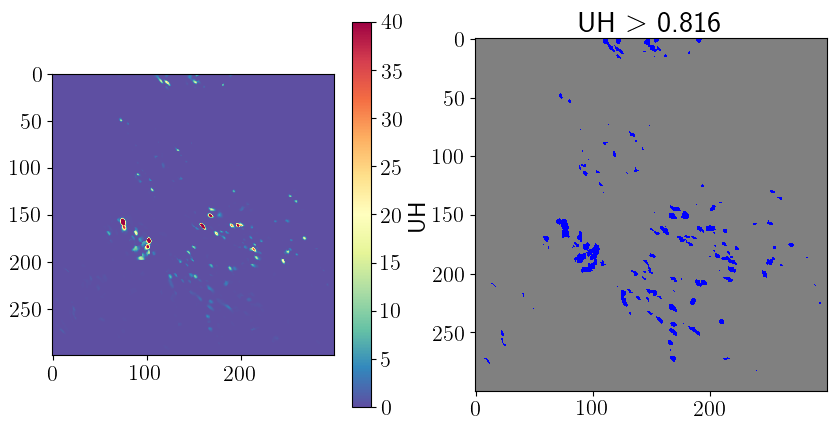

In [71]:
figax_uh = wpe.plot_uh(uh, mask_uh, uh_thres, figax=None, figsize=(10, 5), 
                       vrange=[0, 40], bcmap=mpl.colors.ListedColormap(['gray', 'blue']))

/tmp/ipykernel_130100/272256860.py:5: UserWarning:

ignoring size because footprint is set



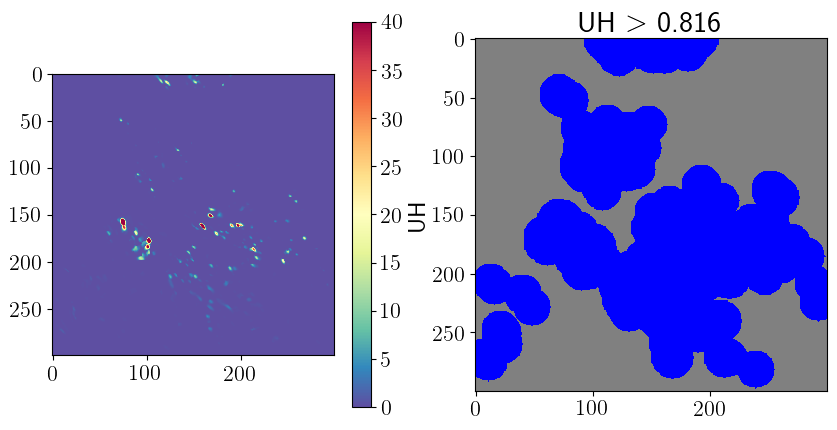

In [72]:
Y, X = np.ogrid[:ksize, :ksize]
dist_from_center = np.sqrt((X - ksize//2+1)**2 + (Y - ksize//2+1)**2)
footprint = dist_from_center <= ksize//2

mask_uh_dilated = grey_dilation(mask_uh, size=(ksize, ksize), footprint=footprint)

figax_uh = wpe.plot_uh(uh, mask_uh_dilated, uh_thres, figax=None, figsize=(10, 5), 
                       vrange=[0, 40], bcmap=mpl.colors.ListedColormap(['gray', 'blue']))

/tmp/ipykernel_130100/915708996.py:1: UserWarning:

ignoring size because footprint is set



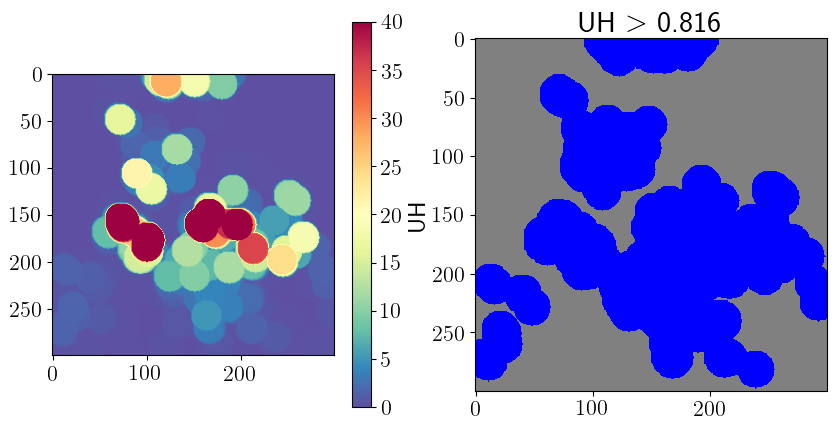

In [73]:
uh_dilated = grey_dilation(uh, size=(ksize, ksize), footprint=footprint)

figax_uh = wpe.plot_uh(uh_dilated, mask_uh_dilated, uh_thres, figax=None, figsize=(10, 5), 
                       vrange=[0, 40], bcmap=mpl.colors.ListedColormap(['gray', 'blue']))

# ALL VIZ

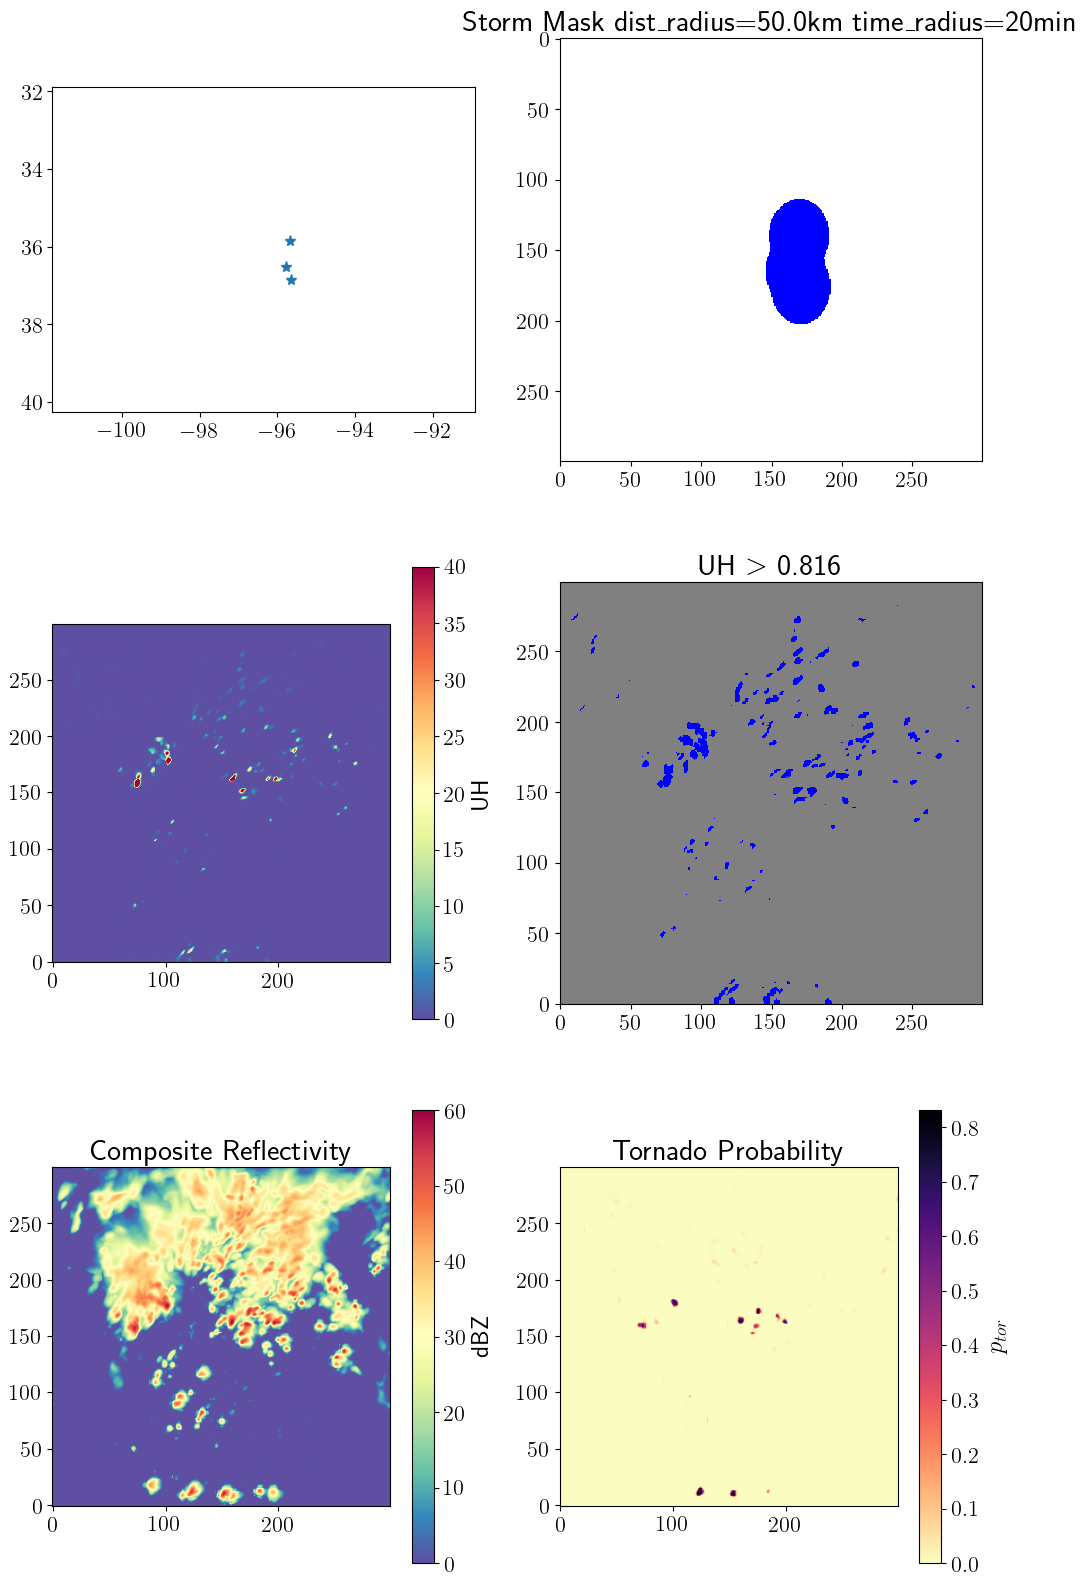

In [74]:
f_, a_ = plt.subplots(3, 2, figsize=(12,20))
a_ = a_.ravel()

invert_y = True

_, _ax_storm = wpe.plot_storms(mask, lons_storm[sel_storms], lats_storm[sel_storms], 
                               thres_dist=thres_dist, thres_time=thres_time, 
                               figax=(f_, a_[:2]), xlims=xlims, ylims=ylims, 
                               invert_yaxis=invert_y, 
                               bcmap=mpl.colors.ListedColormap(['w', 'b']))

_, _ax_uh = wpe.plot_uh(uh, mask_uh, uh_thres=uh_thres, figax=(f_, a_[2:4]), 
                        invert_yaxis=invert_y, vrange=[0, 40], 
                        bcmap=mpl.colors.ListedColormap(['gray', 'blue']))

ZH = wofs_test['COMPOSITE_REFL_10CM'].values[ti]
ml_preds = wofs_test['ML_PREDICTED_TOR'].values[ti]
_, ax_zh_p = wpe.plot_zh_n_probs(ZH, ml_preds, thres_prob=None, figax=(f_, a_[4:]), 
                                 invert_yaxis=invert_y, zrange=[0, 60], #prange=[0,1],
                                 zhcmap='Spectral_r', pcmap='magma_r')

# GENERATE CONFUSION MATRIX

In [75]:
#ML_PREDICTED_TOR     (Time, south_north, west_east) float64 dask.array<chunksize=(10, 300, 300), meta=np.ndarray>
#REFL_10CM            (Time, bottom_top, south_north, west_east) float32 dask.array<chunksize=(10, 50, 300, 300), meta=np.ndarray>
#COMPOSITE_REFL_10CM
ml_preds = wofs_test['ML_PREDICTED_TOR'].values[ti] > .1
cmtx_uh = confusion_matrix(mask_uh.ravel(), ml_preds.ravel()) #tn, fp, fn, tp
#TN: c00, FN c10, TP c11, FP c01 
cmtx_uh

array([[88064,   136],
       [ 1667,   133]])

In [76]:
ml_preds = wofs_test['ML_PREDICTED_TOR'].values[ti] > .5
cmtx_uh = confusion_matrix(mask_uh.ravel(), ml_preds.ravel())
#TN: c00, FN c10, TP c11, FP c01 
cmtx_uh

array([[88160,    40],
       [ 1729,    71]])

In [77]:
tps = cmtx_uh[1, 1]
fns = cmtx_uh[1, 0]
fps = cmtx_uh[0, 1]
compute_csi(tps, fns, fps)

0.03858695652173913

Mixed precision float32 <dtype: 'float32'>
 


posx and posy should be finite values


Max CSI: 0.07. SR=0.426. POD=0.083


posx and posy should be finite values
posx and posy should be finite values


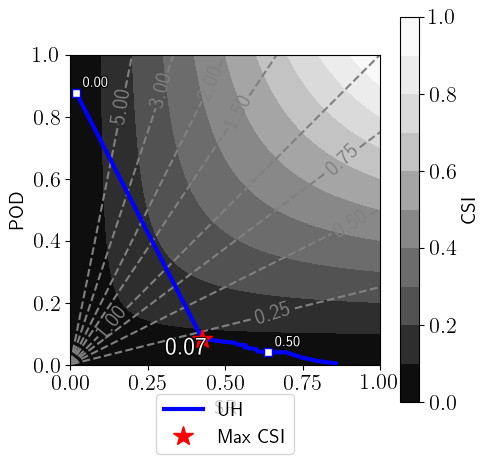

In [94]:
# compute CSI
csithreshs = np.linspace(0, 1, 21)
fname = "" #os.path.join(dirpath, f"{FN_PREFIX}_csi_train_val.png")
fig, ax, scores = plot_csi(mask_uh.ravel(), wofs_test['ML_PREDICTED_TOR'].values[ti].ravel(), 
                 fname, threshs=csithreshs, label='UH', color='blue', save=False, 
                 return_scores=True, fig_ax=None, figsize=(5, 5))

Mixed precision float32 <dtype: 'float32'>
 
2019-04-30_19:05:00 median
Max CSI: 0.02. SR=0.020. POD=0.891


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


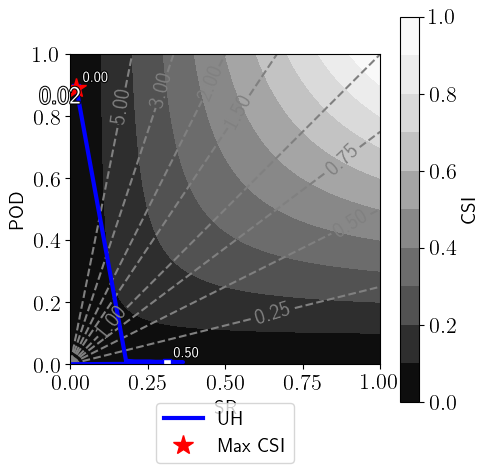

In [95]:
#wofs_prob[stat][0] ftime = '2019-04-30_19:05:00'
print(ftime, stat)
fname = "" #os.path.join(dirpath, f"{FN_PREFIX}_csi_train_val.png")
fig, ax, scores = plot_csi(mask_uh.ravel(), wofs_prob[stat].ravel(), 
                 fname, threshs=csithreshs, label='UH', color='blue', save=False, 
                 return_scores=True, fig_ax=None, figsize=(5, 5))

posx and posy should be finite values


Max CSI: 0.04. SR=0.036. POD=0.875


posx and posy should be finite values
posx and posy should be finite values


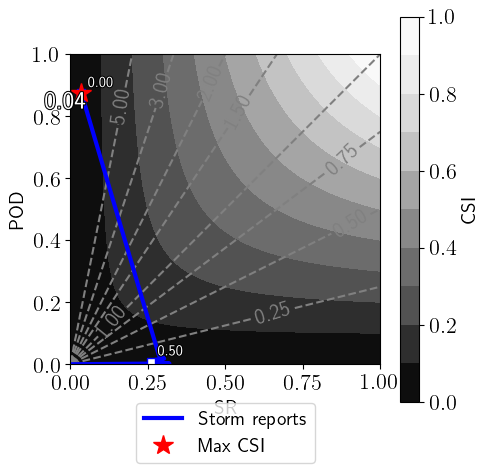

In [96]:
fname = "" #os.path.join(dirpath, f"{FN_PREFIX}_csi_train_val.png")
figax = plot_csi(mask.ravel(), wofs_test['ML_PREDICTED_TOR'].values[ti].ravel(), 
                 fname, threshs=csithreshs, label='Storm reports', color='blue', 
                 save=False, fig_ax=None, figsize=(5, 5))

In [97]:
np.quantile(wofs_prob[stat], [0, .5, .75, .9, .95, 1])

array([0.00000000e+00, 4.77335116e-07, 9.02878401e-06, 5.77881891e-05,
       2.15243258e-04, 6.43495717e-01])

2019-04-30_19:05:00 median
Max CSI: 0.04. SR=0.038. POD=0.921


posx and posy should be finite values
posx and posy should be finite values


posx and posy should be finite values


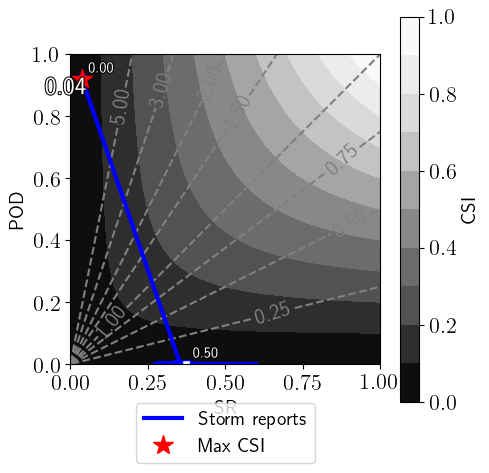

In [98]:
print(ftime, stat)
fname = "" #os.path.join(dirpath, f"{FN_PREFIX}_csi_train_val.png")
fig, ax, scores = plot_csi(mask.ravel(), wofs_prob[stat].ravel(), 
                 fname, threshs=csithreshs, label='Storm reports', color='blue', 
                 save=False, return_scores=True, fig_ax=None, figsize=(5, 5))

In [99]:
def min_max_scale(data, min=None, max=None):
    min_val = np.min(data) if min is not None  else 0
    max_val = np.max(data) if max is not None  else 1
    return (data - min_val) / (max_val - min_val)

from sklearn.preprocessing import normalize, Normalizer, MinMaxScaler

In [100]:
np.quantile(wofs_uh[stat].ravel(), [0, .9, .95, .98, 1])

array([0.00000000e+00, 2.42504101e-02, 1.07881920e-01, 4.56484317e-01,
       2.73242188e+01])

2019-04-30_19:05:00 median
Max CSI: 0.08. SR=0.109. POD=0.197


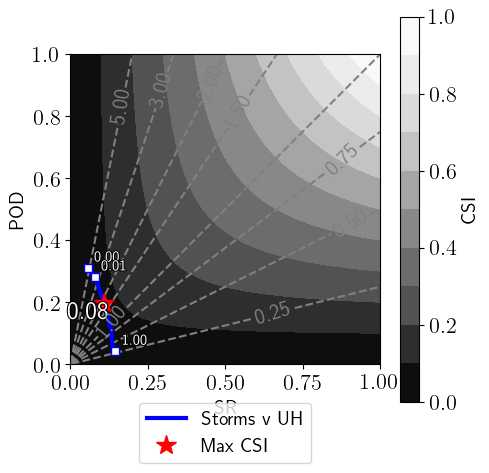

In [101]:
print(ftime, stat)
fname = "" #os.path.join(dirpath, f"{FN_PREFIX}_csi_train_val.png")

uh_min = wofs_uh[stat].min()
uh_max = wofs_uh[stat].max()
uhthreshs = np.logspace(-4, 0, 21, base=10)
fig, ax, scores = plot_csi(mask.ravel(), wofs_uh[stat].ravel(), #wofs_test['UP_HELI_MAX'][ti].ravel(), 
                           fname, threshs=uhthreshs, label='Storms v UH', #threshs=csithreshs
                           color='blue', save=False, return_scores=True, 
                           fig_ax=None, figsize=(5, 5))

In [102]:
np.logspace(-3, 0, 21, base=10)

array([0.001     , 0.00141254, 0.00199526, 0.00281838, 0.00398107,
       0.00562341, 0.00794328, 0.01122018, 0.01584893, 0.02238721,
       0.03162278, 0.04466836, 0.06309573, 0.08912509, 0.12589254,
       0.17782794, 0.25118864, 0.35481339, 0.50118723, 0.70794578,
       1.        ])

In [103]:
np.append(np.array([0]), np.logspace(-4, 0, 20, base=10))

array([0.00000000e+00, 1.00000000e-04, 1.62377674e-04, 2.63665090e-04,
       4.28133240e-04, 6.95192796e-04, 1.12883789e-03, 1.83298071e-03,
       2.97635144e-03, 4.83293024e-03, 7.84759970e-03, 1.27427499e-02,
       2.06913808e-02, 3.35981829e-02, 5.45559478e-02, 8.85866790e-02,
       1.43844989e-01, 2.33572147e-01, 3.79269019e-01, 6.15848211e-01,
       1.00000000e+00])

2019-04-30_19:05:00 median
Max CSI: 0.08. SR=0.110. POD=0.191


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


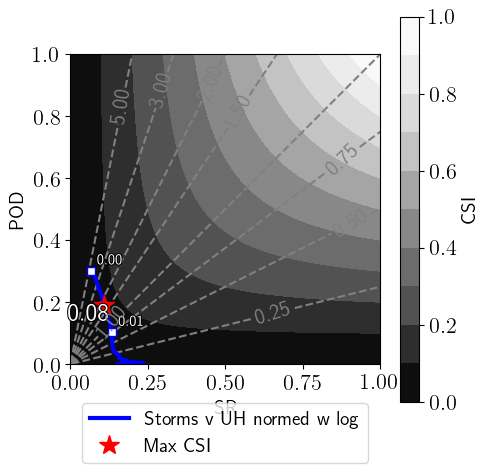

In [104]:
print(ftime, stat)
fname = "" #os.path.join(dirpath, f"{FN_PREFIX}_csi_train_val.png")
uh_norm = normalize(wofs_uh[stat].reshape(-1, 1), norm='max', axis=0)
uhthreshs = np.logspace(-4, 0, 21, base=10)
fig, ax, scores = plot_csi(mask.ravel(), uh_norm.ravel(), #wofs_uh[stat].ravel() #wofs_test['UP_HELI_MAX'][ti].ravel(), 
                           fname, threshs=uhthreshs, label='Storms v UH normed w log', #threshs=csithreshs
                           color='blue', save=False, return_scores=True, 
                           fig_ax=None, figsize=(5, 5))

2019-04-30_19:05:00 median
Max CSI: 0.05. SR=0.056. POD=0.312


posx and posy should be finite values


posx and posy should be finite values
posx and posy should be finite values


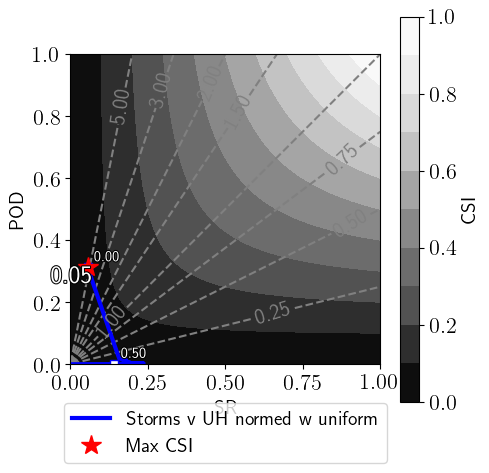

In [105]:
print(ftime, stat)
fname = "" #os.path.join(dirpath, f"{FN_PREFIX}_csi_train_val.png")
uh_norm = normalize(wofs_uh[stat].reshape(-1, 1), norm='max', axis=0)
fig, ax, scores = plot_csi(mask.ravel(), uh_norm.ravel(), #wofs_uh[stat].ravel() #wofs_test['UP_HELI_MAX'][ti].ravel(), 
                           fname, threshs=csithreshs, label='Storms v UH normed w uniform', #threshs=csithreshs
                           color='blue', save=False, return_scores=True, 
                           fig_ax=None, figsize=(5, 5))

In [106]:
uh_qs = np.linspace(0, 1, num=41) #, endpoint=True, base=10)
uh_threshs = np.quantile(wofs_uh[stat], uh_qs)

for i, (q, u) in enumerate(zip(uh_qs, uh_threshs)):
    print(f"[{i}] {q:.05f}: \t{u:.06f}")

[0] 0.00000: 	0.000000
[1] 0.02500: 	0.000000
[2] 0.05000: 	0.000000
[3] 0.07500: 	0.000000
[4] 0.10000: 	0.000000
[5] 0.12500: 	0.000000
[6] 0.15000: 	0.000000
[7] 0.17500: 	0.000000
[8] 0.20000: 	0.000000
[9] 0.22500: 	0.000000
[10] 0.25000: 	0.000000
[11] 0.27500: 	0.000000
[12] 0.30000: 	0.000000
[13] 0.32500: 	0.000000
[14] 0.35000: 	0.000000
[15] 0.37500: 	0.000000
[16] 0.40000: 	0.000000
[17] 0.42500: 	0.000000
[18] 0.45000: 	0.000000
[19] 0.47500: 	0.000000
[20] 0.50000: 	0.000000
[21] 0.52500: 	0.000000
[22] 0.55000: 	0.000000
[23] 0.57500: 	0.000000
[24] 0.60000: 	0.000000
[25] 0.62500: 	0.000000
[26] 0.65000: 	0.000000
[27] 0.67500: 	0.000000
[28] 0.70000: 	0.000000
[29] 0.72500: 	0.000000
[30] 0.75000: 	0.000000
[31] 0.77500: 	0.000000
[32] 0.80000: 	0.000247
[33] 0.82500: 	0.002129
[34] 0.85000: 	0.005862
[35] 0.87500: 	0.012262
[36] 0.90000: 	0.024250
[37] 0.92500: 	0.048684
[38] 0.95000: 	0.107882
[39] 0.97500: 	0.331303
[40] 1.00000: 	27.324219


In [107]:
#uh_Normalizer = Normalizer(norm='max').fit(wofs_uh[stat].reshape(-1, 1))
#uh_Normalizer = MinMaxScaler().fit(wofs_uh[stat].reshape(-1, 1))
#uh_norm = uh_Normalizer.transform(wofs_uh[stat].reshape(-1, 1)).ravel()
#uh_threshs = uh_Normalizer.transform(uh_threshs.reshape(-1, 1)).ravel()

uh_norm = min_max_scale(wofs_uh[stat], min=wofs_uh[stat].min(), max=wofs_uh[stat].max())
uh_threshs = min_max_scale(uh_threshs, min=wofs_uh[stat].min(), max=wofs_uh[stat].max())

In [108]:
uh_threshs

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       9.03267874e-06, 7.79134042e-05, 2.14519157e-04, 4.48771972e-04,
       8.87506075e-04, 1.78170652e-03, 3.94821609e-03, 1.21248995e-02,
       1.00000000e+00])

2019-04-30_19:05:00 median
Max CSI: 0.08. SR=0.105. POD=0.213


posx and posy should be finite values


posx and posy should be finite values
posx and posy should be finite values


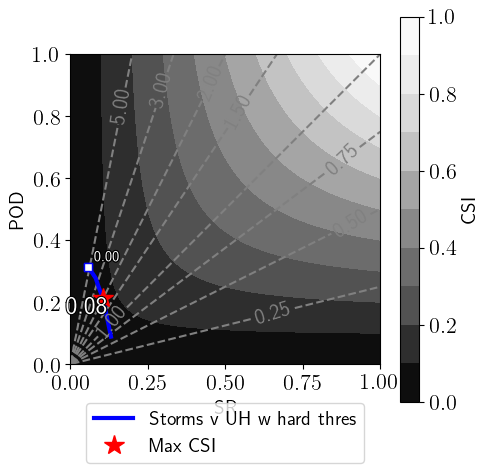

In [109]:
# Use actual UH values for thresholds
print(ftime, stat)
fname = "" #os.path.join(dirpath, f"{FN_PREFIX}_csi_train_val.png")
fig, ax, scores = plot_csi(mask.ravel(), uh_norm.ravel(), #wofs_uh[stat].ravel() #wofs_test['UP_HELI_MAX'][ti].ravel(), 
                           fname, threshs=uh_threshs, label='Storms v UH w hard thres', #threshs=csithreshs
                           color='blue', save=False, return_scores=True, 
                           fig_ax=None, figsize=(5, 5))

2019-04-30_19:05:00 median
Max CSI: 0.30. SR=0.250. POD=0.800


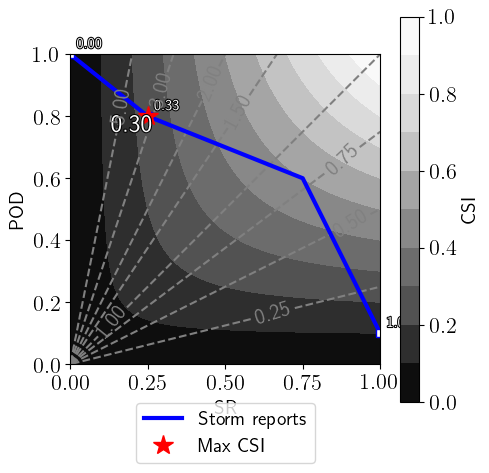

In [110]:
print(ftime, stat)
fname = "" #os.path.join(dirpath, f"{FN_PREFIX}_csi_train_val.png")
figax = plot_csi(mask.ravel(), np.array([0, 1]), #wofs_prob[stat].ravel(), 
                 fname, threshs=np.linspace(0, 1, 4), label='Storm reports', color='blue', 
                 save=False, srs_pods_csis=(np.array([0, .25, .75, 1]), np.array([1, .8, .6, .1]), np.array([.1, .3, .2, .1])), 
                 return_scores=False, fig_ax=None, 
                 figsize=(5, 5))

/home/momoshog/Tornado/tornado_jtti/lydia_scripts/scripts_tensorboard/unet_hypermodel.py:1075: RuntimeWarning:

invalid value encountered in divide



Max CSI: 0.08. SR=0.105. POD=0.211


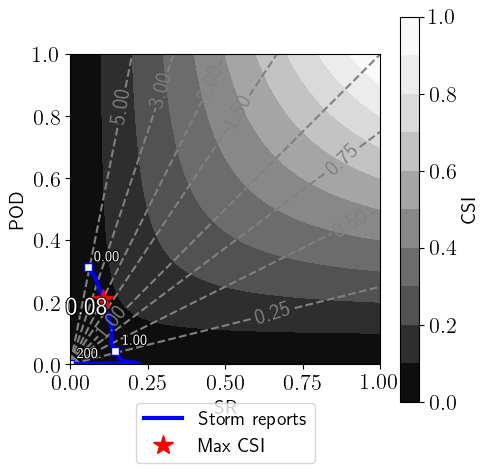

In [111]:
#uh_qs = np.linspace(0, 1, num=21) #, endpoint=True, base=10)
uh_threshs = np.array([0, .01, .02, .025, .05, .1, .2, .25, .5, 1, 5, 10, 20, 25, 40, 50, 80, 100, 200]) #np.quantile(wofs_uh[stat], uh_qs)
results = wpe.compute_performance(mask, wofs_uh[stat], uh_threshs, compute_sr_pod_csi=True)

fname = "" #os.path.join(dirpath, f"{FN_PREFIX}_csi_train_val.png")
figax = plot_csi(mask.ravel(), wofs_uh[stat].ravel(), 
                 fname, threshs=uh_threshs, label='Storm reports', color='blue', 
                 save=False, srs_pods_csis=(results['srs'], results['pods'], results['csis']), 
                 return_scores=False, fig_ax=None, 
                 figsize=(5, 5))

In [112]:
np.nanquantile(wofs_uh[stat], [0, 1])

array([ 0.      , 27.324219], dtype=float32)

Max CSI: 0.08. SR=0.105. POD=0.211


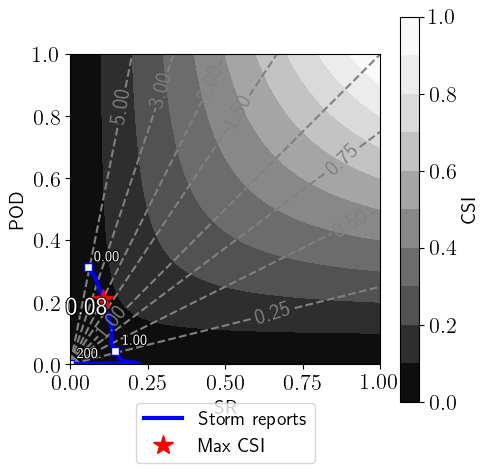

In [113]:
fname = "" #os.path.join(dirpath, f"{FN_PREFIX}_csi_train_val.png")
figax = plot_csi(mask.ravel(), wofs_uh[stat].ravel(), 
                 fname, threshs=uh_threshs, label='Storm reports', color='blue', 
                 save=False, srs_pods_csis=(results['srs'], results['pods'], results['csis']), 
                 return_scores=False, fig_ax=None, 
                 figsize=(5, 5))

In [114]:
confusion_matrix([0, 1, 0, 0, 1], [0, 0, 0, 0, 0])

array([[3, 0],
       [2, 0]])

# NATE ENSEMBLE MEAN/MEDIAN

In [115]:
_tmp = xr.load_dataset('/ourdisk/hpc/ai2es/nsnook/WoFS_summary_data_2019/summary_data_2019-05-18_23:00:00.netcdf')
_tmp

<xarray.Dataset>
Dimensions:                          (member: 18, t_fcst: 37, y: 300, x: 300)
Coordinates:
    latitude                         (y, x) float32 29.61 29.61 ... 37.78 37.78
    longitude                        (y, x) float32 -100.6 -100.6 ... -90.69
Dimensions without coordinates: member, t_fcst, y, x
Data variables:
    ML_probability                   (member, t_fcst, y, x) float32 0.0 ... 0...
    UH                               (member, t_fcst, y, x) float32 0.0 ... 0.0
    COMPOSITE_REFL                   (member, t_fcst, y, x) float32 0.0 ... 0.0
    ens_mean_ML_probability          (t_fcst, y, x) float32 0.0 0.0 ... 0.005859
    ens_mean_UH                      (t_fcst, y, x) float32 0.0 0.0 ... 0.0 0.0
    ens_median_ML_probability        (t_fcst, y, x) float32 0.0 0.0 ... 0.003906
    ens_median_UH                    (t_fcst, y, x) float32 0.0 0.0 ... 0.0 0.0
    ens_percentile90_ML_probability  (t_fcst, y, x) float32 0.0 0.0 ... 0.01172
    ens_percentile90_UH              (t_fcst, y, x) float32 0.0 0.0 ... 0.0 0.0
Attributes:
    description:  WoFS ML tornado forecast summary file
    valid_time:   2019-05-18_23:00:00

In [116]:
_2019reports = pd.read_csv('/ourdisk/hpc/ai2es/tornado/stormreports/processed/tornado_reports_2019.csv')
_2019reports.head(12)

xr version 2023.8.0
np version 1.24.2
pd version 1.5.3


,start_time_unix_sec,end_time_unix_sec,start_latitude_deg,end_latitude_deg,start_longitude_deg,end_longitude_deg,f_or_ef_rating,width_metres
0,1555709460,1555709580,37.6990,37.7200,281.2110,281.2190,EF1,38.100463
1,1555721700,1555722000,38.9302,38.9861,282.6217,282.6485,EF0,30.480371
2,1556306340,1556306580,39.5647,39.5934,283.3897,283.4305,EF1,45.720556
3,1565570820,1565571120,39.6813,39.6950,258.3424,258.3570,EF1,53.340649
4,1555228200,1555228320,30.4754,30.4872,271.4405,271.4529,EF1,15.240185
5,1554686340,1554686520,29.9528,29.9831,269.7631,269.7883,EF0,15.240185
6,1577667000,1577667420,34.7541,34.7946,272.9223,272.9959,EF0,15.240185
7,1558249320,1558249500,31.3732,31.3840,267.0010,267.0168,EF0,24.384297
8,1567688520,1567690260,34.6564,34.7957,282.9476,282.7846,EF2,60.960741
9,1556209320,1556209380,30.3935,30.3935,270.5547,270.5589,EF1,7.620093


In [117]:
_2019reports.shape

(1533, 8)

In [118]:
_2019reports.sort_values(by=['start_time_unix_sec', 'end_time_unix_sec'], inplace=True)
_2019reports.head(8)

,start_time_unix_sec,end_time_unix_sec,start_latitude_deg,end_latitude_deg,start_longitude_deg,end_longitude_deg,f_or_ef_rating,width_metres
22,1546598280,1546598400,31.6165,31.6169,274.7212,274.7237,EF0,10.668130
21,1546600200,1546600320,31.5976,31.6003,275.0365,275.0389,EF1,27.432334
30,1546804740,1546805040,36.9600,36.9600,237.9600,237.9600,EF0,2.033041
36,1546805940,1546806000,36.9569,36.9569,237.9819,237.9819,EF0,2.033041
34,1546960800,1546961160,41.3226,41.3303,279.1847,279.2715,EF1,22.860278
43,1546964700,1546964880,41.4400,41.4400,279.9400,279.9400,EF1,121.921483
35,1547767200,1547767500,36.8400,36.8403,240.4400,240.4560,EF1,6.096074
32,1547901720,1547901960,32.8759,32.8960,270.4830,270.4806,EF1,76.200927


In [119]:
_lat_storms = _2019reports['start_latitude_deg']

In [120]:
_lon_storms = _2019reports['start_longitude_deg']

In [121]:
_2019reports['start_datetime_utc'] = pd.to_datetime(_2019reports['start_time_unix_sec'], unit='s')
_2019reports['end_datetime_utc'] = pd.to_datetime(_2019reports['end_time_unix_sec'], unit='s')

_2019reports[['start_datetime_utc', 'end_datetime_utc']].head(12)

,start_datetime_utc,end_datetime_utc
22,2019-01-04 10:38:00,2019-01-04 10:40:00
21,2019-01-04 11:10:00,2019-01-04 11:12:00
30,2019-01-06 19:59:00,2019-01-06 20:04:00
36,2019-01-06 20:19:00,2019-01-06 20:20:00
34,2019-01-08 15:20:00,2019-01-08 15:26:00
43,2019-01-08 16:25:00,2019-01-08 16:28:00
35,2019-01-17 23:20:00,2019-01-17 23:25:00
32,2019-01-19 12:42:00,2019-01-19 12:46:00
38,2019-01-19 13:38:00,2019-01-19 13:41:00
39,2019-01-19 13:44:00,2019-01-19 13:47:00


In [122]:
_2019reports_re = _2019reports.set_index('start_datetime_utc')
_2019reports_re.head(8)

,start_time_unix_sec,end_time_unix_sec,start_latitude_deg,end_latitude_deg,start_longitude_deg,end_longitude_deg,f_or_ef_rating,width_metres,end_datetime_utc
start_datetime_utc,,,,,,,,,
2019-01-04 10:38:00,1546598280,1546598400,31.6165,31.6169,274.7212,274.7237,EF0,10.668130,2019-01-04 10:40:00
2019-01-04 11:10:00,1546600200,1546600320,31.5976,31.6003,275.0365,275.0389,EF1,27.432334,2019-01-04 11:12:00
2019-01-06 19:59:00,1546804740,1546805040,36.9600,36.9600,237.9600,237.9600,EF0,2.033041,2019-01-06 20:04:00
2019-01-06 20:19:00,1546805940,1546806000,36.9569,36.9569,237.9819,237.9819,EF0,2.033041,2019-01-06 20:20:00
2019-01-08 15:20:00,1546960800,1546961160,41.3226,41.3303,279.1847,279.2715,EF1,22.860278,2019-01-08 15:26:00
2019-01-08 16:25:00,1546964700,1546964880,41.4400,41.4400,279.9400,279.9400,EF1,121.921483,2019-01-08 16:28:00
2019-01-17 23:20:00,1547767200,1547767500,36.8400,36.8403,240.4400,240.4560,EF1,6.096074,2019-01-17 23:25:00
2019-01-19 12:42:00,1547901720,1547901960,32.8759,32.8960,270.4830,270.4806,EF1,76.200927,2019-01-19 12:46:00


In [123]:
_2019reports_re['2019-03-30':'2019-06-03'].head(8)

,start_time_unix_sec,end_time_unix_sec,start_latitude_deg,end_latitude_deg,start_longitude_deg,end_longitude_deg,f_or_ef_rating,width_metres,end_datetime_utc
start_datetime_utc,,,,,,,,,
2019-04-06 19:10:00,1554577800,1554577920,30.6936,30.6979,262.8032,262.8041,EF0,45.720556,2019-04-06 19:12:00
2019-04-07 12:24:00,1554639840,1554639900,28.3691,28.3690,262.3357,262.3450,EF0,9.144111,2019-04-07 12:25:00
2019-04-07 17:42:00,1554658920,1554659040,29.6502,29.6579,264.7982,264.7998,EF1,15.240185,2019-04-07 17:44:00
2019-04-07 17:58:00,1554659880,1554659940,30.3189,30.3197,264.3555,264.3564,EF0,9.144111,2019-04-07 17:59:00
2019-04-07 23:02:00,1554678120,1554678240,31.0184,31.0433,268.9288,268.9273,EF1,38.100463,2019-04-07 23:04:00
2019-04-08 00:44:00,1554684240,1554684420,30.2184,30.2295,269.2019,269.2053,EF1,15.240185,2019-04-08 00:47:00
2019-04-08 01:19:00,1554686340,1554686520,29.9528,29.9831,269.7631,269.7883,EF0,15.240185,2019-04-08 01:22:00
2019-04-08 10:15:00,1554718500,1554718740,33.9128,33.9301,273.2311,273.2630,EF0,99.061205,2019-04-08 10:19:00


In [124]:
#pd.date_range(_2019reports_re['start_datetime_utc'], _2019reports_re['end_datetime_utc'], freq='1M')
np.arange(_2019reports_re['start_time_unix_sec'].iloc[0], _2019reports_re['end_time_unix_sec'].iloc[0], 1e2)

array([1.54659828e+09, 1.54659838e+09])

In [125]:
def new_reports_list(df, dstart, dend):
    df_trim = df[dstart:dend]
    df_copy = df_trim.copy()
    for row in df_trim:
        pass

In [126]:
_times_storms = np.array([d.to_pydatetime() for d in pd.to_datetime(_2019reports['start_time_unix_sec'].values, unit='s')])
_times_storms

array([datetime.datetime(2019, 1, 4, 10, 38),
       datetime.datetime(2019, 1, 4, 11, 10),
       datetime.datetime(2019, 1, 6, 19, 59), ...,
       datetime.datetime(2019, 12, 29, 22, 32),
       datetime.datetime(2019, 12, 29, 23, 13),
       datetime.datetime(2019, 12, 30, 0, 50)], dtype=object)

In [127]:
_times_storms_end = np.array([d.to_pydatetime() for d in pd.to_datetime(_2019reports['end_time_unix_sec'].values, unit='s')])
_times_storms_end

array([datetime.datetime(2019, 1, 4, 10, 40),
       datetime.datetime(2019, 1, 4, 11, 12),
       datetime.datetime(2019, 1, 6, 20, 4), ...,
       datetime.datetime(2019, 12, 29, 22, 35),
       datetime.datetime(2019, 12, 29, 23, 18),
       datetime.datetime(2019, 12, 30, 0, 57)], dtype=object)

In [128]:
df_storm_report.head(8) #['DateTime']

,Time,DateTime,F_Scale,Location,County,State,Lat,Lon,Comments
0,6,2019-04-29 00:06:00,UNK,5 WSW BRUSHYKNOB,DOUGLAS,MO,36.93,-92.57,NWS STORM SURVEY CONFIRMED AN EF-1 TORNADO WIT...
1,28,2019-04-29 00:28:00,UNK,2 N OZARK,CHRISTIAN,MO,37.07,-93.20,*** 3 INJ *** AN NWS STORM SURVEY CONFIRMED AN...
2,30,2019-04-29 00:30:00,UNK,4 WSW NORWOOD,WRIGHT,MO,37.10,-92.49,A NWS SURVEY TEAM CONFIRMED AN EF-1 TORNADO WH...
3,38,2019-04-29 00:38:00,UNK,6 NW MILLER,LAWRENCE,MO,37.29,-93.91,AN NWS STORM SURVEY CONFIRMED AN EF1 TORNADO T...
4,40,2019-04-29 00:40:00,UNK,1 SW EUDORA,POLK,MO,37.45,-93.56,AN NWS STORM SURVEY CONFIRMED AN EF1 TORNADO T...
5,58,2019-04-29 00:58:00,UNK,4 SW MOUNTAIN GROVE,WRIGHT,MO,37.09,-92.32,A NWS SURVEY TEAM CONFIRMED AN EF-0 TORNADO WH...
6,115,2019-04-29 01:15:00,UNK,2 NW WILLARD,GREENE,MO,37.33,-93.46,CORRECTS PREVIOUS TORNADO REPORT FROM 2 NW WIL...
7,121,2019-04-29 01:21:00,UNK,4 NE WILLARD,GREENE,MO,37.36,-93.39,AN NWS STORM SURVEY CONFIRMED AN EF1 TORNADO T...


In [129]:
dtime

cftime.DatetimeGregorian(2019, 4, 30, 19, 40, 0, 0, has_year_zero=False)

In [130]:
_2019reports_re['2019-04-28':'2019-06-03'].head(8)

,start_time_unix_sec,end_time_unix_sec,start_latitude_deg,end_latitude_deg,start_longitude_deg,end_longitude_deg,f_or_ef_rating,width_metres,end_datetime_utc
start_datetime_utc,,,,,,,,,
2019-04-29 09:10:00,1556529000,1556529180,38.5032,38.4879,265.1739,265.2066,EF0,4.572056,2019-04-29 09:13:00
2019-04-30 16:53:00,1556643180,1556643660,35.8850,35.9170,263.1430,263.1770,EF1,9.144111,2019-04-30 17:01:00
2019-04-30 17:13:00,1556644380,1556644440,35.9900,35.9940,263.2540,263.2600,EF1,6.096074,2019-04-30 17:14:00
2019-04-30 17:22:00,1556644920,1556644980,34.5040,34.5060,263.1298,263.1316,EF1,9.144111,2019-04-30 17:23:00
2019-04-30 17:23:00,1556644980,1556645460,34.5060,34.5257,263.1316,263.1508,EF1,9.144111,2019-04-30 17:31:00
2019-04-30 19:03:00,1556650980,1556651400,35.7058,35.7193,264.1253,264.1665,EF0,30.480371,2019-04-30 19:10:00
2019-04-30 19:14:00,1556651640,1556651760,36.3800,36.3886,263.9489,263.9684,EF0,15.240185,2019-04-30 19:16:00
2019-04-30 19:29:00,1556652540,1556652600,35.8546,35.8566,264.3078,264.3102,EF0,38.100463,2019-04-30 19:30:00


In [131]:
# TODO: generate report row for each minute within the each start to end range
#
_mask, _sel_storms, _tree = wpe.create_storm_mask(xlats, xlons, datetime(2019, 4, 30, 16, 56), _lat_storms, #dtime
                                               _lon_storms, _times_storms, GRIDSIZE, 
                                               thres_dist=thres_dist, 
                                               thres_time=thres_time, 
                                               kdworkers=-1,
                                               times_storms_end=_times_storms_end)


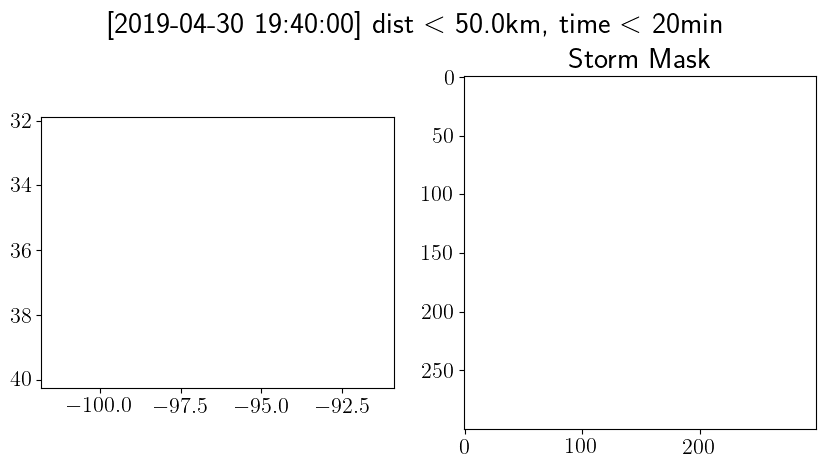

In [132]:
ylims = np.quantile(xlats, [0, 1])
xlims = np.quantile(xlons, [0, 1])

figax_storms = wpe.plot_storms(_mask, _lon_storms[_sel_storms], _lat_storms[_sel_storms], 
                               figax=None, figsize=(10, 5), xlims=xlims, ylims=ylims, 
                               invert_yaxis=True, 
                               bcmap=mpl.colors.ListedColormap(['w', 'blue']))
figax_storms[0].suptitle(rf'[{dtime}] dist $<$ {thres_dist}km, time $<$ {thres_time}min');

# COMPUTE UH DISTRIBUTION FOR A DAY

In [133]:
import dask

In [134]:
ftime = None #'2019-04-30_19:05:00'
sel_files_ftime = select_files(df_all_files, init_time, ftime, emember=None)
print(sel_files_ftime.shape)

concat_dim = 'FILE'
_sel_files = list(sel_files_ftime['filename_path'].iloc[:20])
wofs_day = None
with dask.config.set(**{'array.slicing.split_large_chunks': True}): #file_cache_maxsize
    wofs_day = xr.open_mfdataset(_sel_files, concat_dim=concat_dim, 
                                   chunks='auto', combine='nested', engine="netcdf4",
                                   coords='minimal', decode_times=False) #parallel=True, 
print(wofs_day['Time'])

#getattr(my_instance, method_name)() 'UP_HELI_MAX'
#elif stat == 'mean':
#wofs_cZH[stat] = wofs_preds['COMPOSITE_REFL_10CM'].mean().values
#wofs_prob[stat] = wofs_preds['ML_PREDICTED_TOR'].mean().values
#wofs_uh_mean = wofs_preds['UP_HELI_MAX'].mean().values
#wofs_uh_median = wofs_preds['UP_HELI_MAX'].median().values

(1350, 5)
<xarray.DataArray 'Time' (Time: 19)>
array([578343600, 578343900, 578344200, 578344500, 578344800, 578345100,
       578345400, 578345700, 578346000, 578346300, 578346600, 578346900,
       578347200, 578347500, 578347800, 578348100, 578348400, 578348700,
       578349000])
Coordinates:
  * Time     (Time) int64 578343600 578343900 578344200 ... 578348700 578349000
    XTIME    (Time) float32 dask.array<chunksize=(19,), meta=np.ndarray>


In [135]:
np.nanquantile(wofs_day['UP_HELI_MAX'].values, [0, .9, .95, .99, 1]) #0.0, .033, .016, 5.16, 241.25

xr version 2023.8.0
np version 1.24.2
pd version 1.5.3


array([0.00000000e+00, 3.19366455e-02, 1.31408677e-01, 2.58789062e+00,
       1.65812500e+02])

In [136]:
wofs_uh_min = wofs_day['UP_HELI_MAX'].min().values #
wofs_uh_max = wofs_day['UP_HELI_MAX'].max().values
wofs_uh_min.min(), wofs_uh_max.max()

(0.0, 165.8125)

# EXAMPLE KDTree

In [137]:
x, y = np.mgrid[0:4, 0:4]
x

array([[0, 0, 0, 0],
       [1, 1, 1, 1],
       [2, 2, 2, 2],
       [3, 3, 3, 3]])

In [138]:
y

array([[0, 1, 2, 3],
       [0, 1, 2, 3],
       [0, 1, 2, 3],
       [0, 1, 2, 3]])

In [139]:
points = np.c_[x.ravel(), y.ravel()]
points

array([[0, 0],
       [0, 1],
       [0, 2],
       [0, 3],
       [1, 0],
       [1, 1],
       [1, 2],
       [1, 3],
       [2, 0],
       [2, 1],
       [2, 2],
       [2, 3],
       [3, 0],
       [3, 1],
       [3, 2],
       [3, 3]])

In [140]:
tree = spatial.cKDTree(points)
tree.query_ball_point([2, 0], 1)

[4, 8, 9, 12]

In [141]:
tree.query_ball_point(([1.5, .1], [3, 3]), 2)

array([list([0, 1, 4, 5, 6, 8, 9, 10, 12, 13]),
       list([7, 10, 11, 13, 14, 15])], dtype=object)

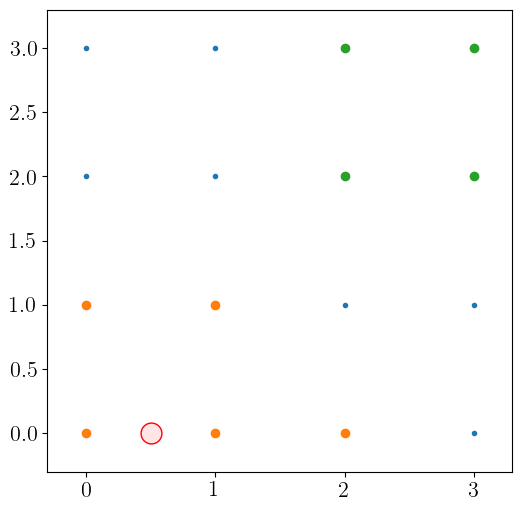

In [142]:
f_, a_ = plt.subplots(1, 1, figsize=(6, 6))
points = np.asarray(points)
a_.plot(points[:,0], points[:,1], '.')

for results in tree.query_ball_point(([.5, 0], [3, 3]), 1.5):
    nearby_points = points[results]
    a_.plot(nearby_points[:,0], nearby_points[:,1], 'o')

a_.plot(.5, 0, 'ro', ms=15, markeredgecolor=(1, 0, 0, 1), 
        markerfacecolor=(1, 0, 0, 0.1))

a_.margins(0.1, 0.1)